# Plot terminus picks over images analyzed and terminus position timeseries

#### Jukes Liu

## 1) Import packages, set paths, and read in csv files

In [67]:
# import sys
# # !{sys.executable} -m pip install fiona
# !{sys.executable} -m pip install opencv-python

In [674]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import matplotlib.image as mpimg
import cv2
import pandas as pd    
from time import sleep
from IPython.display import clear_output
import scipy.stats
import datetime
import shutil

csvpaths = '/home/jukes/Documents/Sample_glaciers/'
basepath = '/media/jukes/jukes1/LS8aws/'
massorsize = "mass"

Read in __image dates__ from imgdates.csv

In [2]:
#Read in datetags csv as datetime_df
datetime_df = pd.read_csv(csvpaths+'imgdates.csv', sep=',', dtype=str, header=0, names=['Scene', 'datetimes'])
print(datetime_df.shape)
datetime_df.head()

(864, 2)


Scene   datetimes
510   LC80090132013101LGN01  2013-04-11
1612  LC80090142013101LGN01  2013-04-11
577   LC82330172013102LGN01  2013-04-12
940   LC82330152013102LGN01  2013-04-12
445   LC80080142013110LGN01  2013-04-20

Read in csv with the __metric and order__ for each terminus pick from terminuspicks_massorsize_date.csv

In [1069]:
analysis_date = '2019_10_22'

order_df = pd.read_csv(csvpaths+'terminuspicks_'+massorsize+'_'+analysis_date+'.csv', sep=',', dtype=str, header=1, usecols=[0,1,2,3,4])
order_df = order_df.dropna()
print(order_df.shape)
order_df.head(10)

(3562, 5)


BoxID                  Scene Scale   Scaled_Mass Order
0   001  LC80310052014242LGN00   048  0.0000000001     5
1   001  LC80310052014242LGN00   047  0.0000000003     4
2   001  LC80310052014242LGN00   045  0.0000000006     3
3   001  LC80310052014242LGN00   044  0.0000000027     2
4   001  LC80310052014242LGN00   043  0.0000000054     1
5   001  LC80310052014226LGN00   048  0.0000000001     4
6   001  LC80310052014226LGN00   047  0.0000000003     3
7   001  LC80310052014226LGN00   045  0.0000000009     2
8   001  LC80310052014226LGN00   044  0.0000000032     1
9   001  LC80340052016109LGN00   019  0.1246617297     5

Read in __centerline information__ for each terminus box rom Boxes_coords_pathrows.csv

In [912]:
centerline_df = pd.read_csv(csvpaths+'Boxes_coords_pathrows.csv', sep=',', dtype=str, header=0)
centerline_df = centerline_df.set_index('BoxID')
print(centerline_df.shape)
centerline_df

(10, 4)


midpoint_x midpoint_y            cline_slope     cline_intercept
BoxID                                                                 
001        117.0      164.5   -0.11888111888111888   178.4090909090909
002        468.0      575.5    0.03345070422535211   559.8450704225352
004        500.0      651.0    -0.2899305555555556   795.9652777777778
033        362.5      473.0  -0.006185567010309278  475.24226804123714
120        111.0      148.5   0.055944055944055944   142.2902097902098
174        260.5      344.5    -0.3231939163498099   428.6920152091255
235        177.0      201.0     0.2222222222222222  161.66666666666669
259        215.0      484.0     0.0705521472392638   468.8312883435583
277        144.5      204.0   -0.04891304347826087   211.0679347826087
531        166.0      250.5   -0.15637860082304528   276.4588477366255

Read in __glacier velocities__ from Glacier_velocities.csv

In [913]:
#Read in glacier velocity data
flowspeed_df= pd.read_csv(csvpaths+'Glacier_velocities.csv', sep=',', dtype=str, header=0, usecols=[1,2,3])
flowspeed_df = flowspeed_df.set_index('BoxID')

## 2) Plot analyzed images and terminus picks for one glacier sequentially

If images have not been converted to png from pgm, run the following cell but change the BoxID to the right ID:

In [617]:
%%bash

cd /media/jukes/jukes1/LS8aws/Box277/resized/
mogrify -format png *.pgm

#### Load in the images, scene names, and dat file names for all the resulting terminus picks

In [1059]:
BOI= '277'
print("Box"+BOI)

metric = "terminus_highest"+massorsize+"/"
imagepath = basepath+"Box"+BOI+"/resized/"

#grab the order_df subset for just the box:
order_box_df = order_df[order_df["BoxID"]==BOI].copy()

#make results directory in BoxID folder if it doesn't already exist
if os.path.exists(basepath+"Box"+BOI+"/Results/"):
    shutil.rmtree(basepath+"Box"+BOI+"/Results/")
    print("Results folder wiped and new created")
    os.mkdir(basepath+"Box"+BOI+"/Results/")
#OTHERWISE, create the folder and download into it
else:
    os.mkdir(basepath+"Box"+BOI+"/Results/")
    print("Results  folder made")

Box277
Results folder wiped and new created


Drop BoxID column and NaNs from the order_box_df

In [1060]:
order_box_df = order_box_df.drop('BoxID', axis=1)
order_box_df = order_box_df.dropna()
print(order_box_df.shape)
order_box_df.head()

(352, 4)


Scene Scale   Scaled_Mass Order
2577  LC80010142015211LGN00   032  0.0000894688     5
2578  LC80010142015211LGN00   031  0.0001724100     4
2579  LC80010142015211LGN00   030  0.0003097753     3
2580  LC80010142015211LGN00   029  0.0007395270     2
2581  LC80010142015211LGN00   028  0.0015441132     1

In [1061]:
#make lists to store image data and grab image files
image_arrays = []
dats = []
trimdats = []
imgnames = []
boxids = []
scales = []

#image path
imgfiles = os.listdir(imagepath)

for imgfile in imgfiles:
    #grab image files and append to images list
    if imgfile.endswith(BOI+".png"):
#         print(imgfile)
        image = mpimg.imread(imagepath+imgfile)
        imgname = imgfile[0:-4]
        scenename = imgname[7:-16]
#         print(imgname, scenename)
        
        pathtodat = imagepath+imgname+".pgm_max_gaussian/"+metric
        datfiles = os.listdir(pathtodat)
        
        #if there are datfiles, grab the trimmed and non-trimmed files
        if len(datfiles) > 1: 
            #find the trimmed dat file and the original
            for dat in datfiles:
                if "trim" in dat:
                    datfile_trim = dat
                    #append to trimmed dats list
                    trimdats.append(datfile_trim)
                    #grab the scale and append the equivalent original dat
                    scale = dat[-7:-4]
                    datfile = "terminus_"+scale+".dat"
                    dats.append(datfile)
                    
                    #append the image array and the image name to the list
                    image_arrays.append(image)
                    imgnames.append(scenename)
                    boxids.append(BOI)
                    scales.append(scale)


#         print(image, datfile_trim, datfile)
#         else:
#             print("NO DAT FILES CREATED FOR TERMINUS PICK")

print(len(image_arrays), len(dats), len(trimdats), len(imgnames),len(boxids), len(scales))
images_df = pd.DataFrame(list(zip(imgnames, boxids, image_arrays, dats, trimdats, scales)),
              columns=['Scene','BoxID','Image_array', 'Dat_filename', "Trimmed_dat_filename", "Scale"])

352 352 352 352 352 352


In [1062]:
print(images_df.shape)
images_df.head(15)

(352, 6)


Scene BoxID  \
0   LC80010142016182LGN00   277   
1   LC80010142016182LGN00   277   
2   LC80010142016182LGN00   277   
3   LC80010142016182LGN00   277   
4   LC80010142016182LGN00   277   
5   LC80010142014288LGN00   277   
6   LC80010142014288LGN00   277   
7   LC80010142014288LGN00   277   
8   LC80010142014288LGN00   277   
9   LC80010142014288LGN00   277   
10  LC80010142013317LGN00   277   
11  LC80010142013317LGN00   277   
12  LC80010142013317LGN00   277   
13  LC80010142013317LGN00   277   
14  LC80010142013317LGN00   277   

                                          Image_array      Dat_filename  \
0   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_033.dat   
1   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_031.dat   
2   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_034.dat   
3   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_030.dat   
4   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_032.dat   
5   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_040.dat   
6   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_042.dat   
7   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_039.dat   
8   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_038.dat   
9   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_041.dat   
10  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_048.dat   
11  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_046.dat   
12  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_049.dat   
13  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_045.dat   
14  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_047.dat   

     Trimmed_dat_filename Scale  
0   terminus_trim_033.dat   033  
1   terminus_trim_031.dat   031  
2   terminus_trim_034.dat   034  
3   terminus_trim_030.dat   030  
4   terminus_trim_032.dat   032  
5   terminus_trim_040.dat   040  
6   terminus_trim_042.dat   042  
7   terminus_trim_039.dat   039  
8   terminus_trim_038.dat   038  
9   terminus_trim_041.dat   041  
10  terminus_trim_048.dat   048  
11  terminus_trim_046.dat   046  
12  terminus_trim_049.dat   049  
13  terminus_trim_045.dat   045  
14  terminus_trim_047.dat   047

#### Join dates to images_df by joining on Scene:

In [1063]:
images_df.sort_values(by='Scene')
datetime_df = datetime_df.sort_values(by='Scene')
print(datetime_df.shape)

(864, 2)


In [1064]:
new_df = images_df.merge(datetime_df, how= 'inner', on = 'Scene')
#sort by ascending datetime
dated_images_df = new_df.sort_values(by='datetimes', ascending = True)
#check the shape
print(dated_images_df.shape)
dated_images_df.head()

(352, 7)


Scene BoxID  \
316  LC80010142013141LGN01   277   
314  LC80010142013141LGN01   277   
313  LC80010142013141LGN01   277   
312  LC80010142013141LGN01   277   
315  LC80010142013141LGN01   277   

                                           Image_array      Dat_filename  \
316  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_044.dat   
314  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_041.dat   
313  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_042.dat   
312  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_040.dat   
315  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_043.dat   

      Trimmed_dat_filename Scale   datetimes  
316  terminus_trim_044.dat   044  2013-05-21  
314  terminus_trim_041.dat   041  2013-05-21  
313  terminus_trim_042.dat   042  2013-05-21  
312  terminus_trim_040.dat   040  2013-05-21  
315  terminus_trim_043.dat   043  2013-05-21

#### Join "order" to dated_images_df by joining on scale and scene

In [1065]:
final_images_df = dated_images_df.merge(order_box_df, how='inner', on=['Scene', 'Scale'])
final_images_df.head()

Scene BoxID  \
0  LC80010142013141LGN01   277   
1  LC80010142013141LGN01   277   
2  LC80010142013141LGN01   277   
3  LC80010142013141LGN01   277   
4  LC80010142013141LGN01   277   

                                         Image_array      Dat_filename  \
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_044.dat   
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_041.dat   
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_042.dat   
3  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_040.dat   
4  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_043.dat   

    Trimmed_dat_filename Scale   datetimes   Scaled_Mass Order  
0  terminus_trim_044.dat   044  2013-05-21  0.0000000261     5  
1  terminus_trim_041.dat   041  2013-05-21  0.0000002250     2  
2  terminus_trim_042.dat   042  2013-05-21  0.0000001126     3  
3  terminus_trim_040.dat   040  2013-05-21  0.0000004578     1  
4  terminus_trim_043.dat   043  2013-05-21  0.0000000546     4

#### Grab the unique scenes from the final dataframe

In [1066]:
uniquescenes = set(list(final_images_df['Scene']))
len(uniquescenes)

72

### Show each image & all (up to 5) terminus picks at a time:

In [1067]:
#define a function to help us find the intersection of a line and a collection of points:
#determines if an input value is within a certain range/interval or a setvalue:
def within(value, setval, interval):
    if value >= setval-interval and value <= setval+interval:
        return True
    else:
        return False

terminus_trim_027.dat
terminus_trim_026.dat
terminus_trim_028.dat
terminus_trim_040.dat
terminus_trim_042.dat
terminus_trim_005.dat
terminus_trim_034.dat
terminus_trim_027.dat
terminus_trim_043.dat
terminus_trim_040.dat
terminus_trim_031.dat
terminus_trim_011.dat
terminus_trim_032.dat
terminus_trim_033.dat
terminus_trim_037.dat
terminus_trim_017.dat
terminus_trim_042.dat
terminus_trim_029.dat
terminus_trim_039.dat
terminus_trim_023.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_039.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_006.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_042.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_040.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_032.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_018.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_042.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_020.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_026.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_035.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_042.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_031.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_028.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_043.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_033.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_026.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_038.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_029.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_044.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_040.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_024.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_040.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_021.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_025.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_036.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_006.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_006.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_030.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_033.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_034.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_016.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_029.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_037.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_038.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_030.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_041.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_038.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_028.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_045.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_032.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_032.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_036.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_041.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_005.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_036.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_040.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_036.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_035.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_009.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_007.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_036.dat


/home/jukes/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


terminus_trim_038.dat
Done.


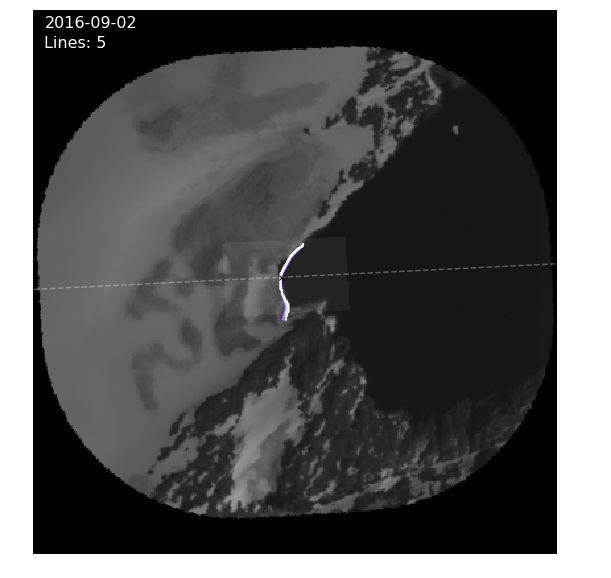

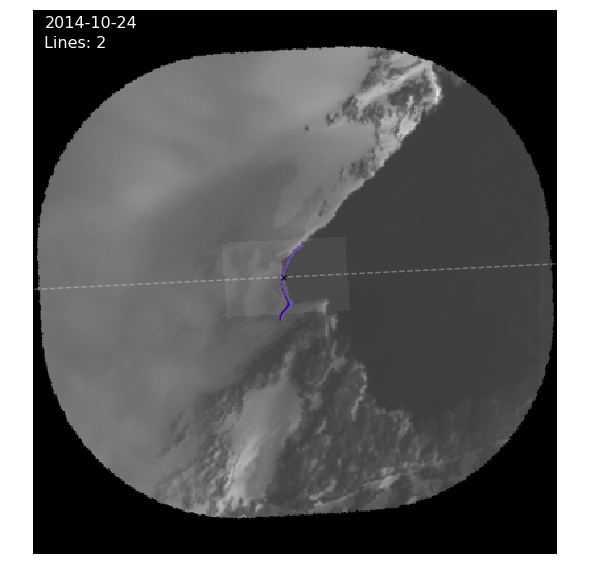

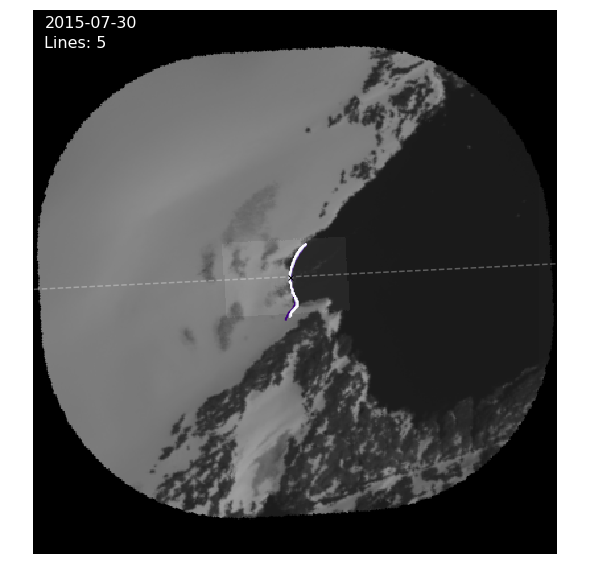

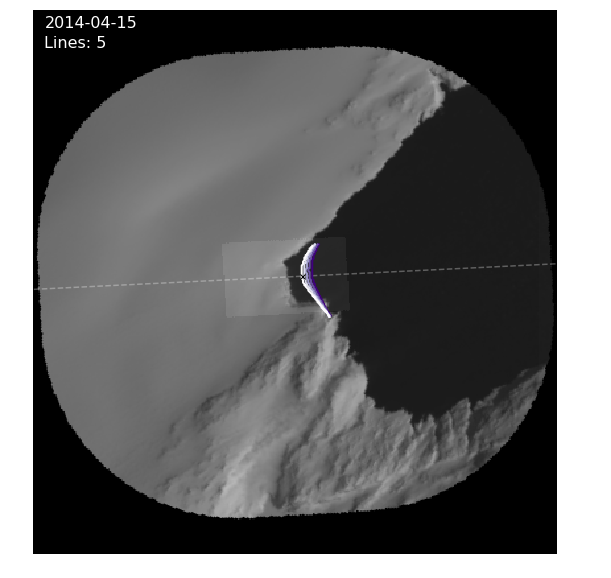

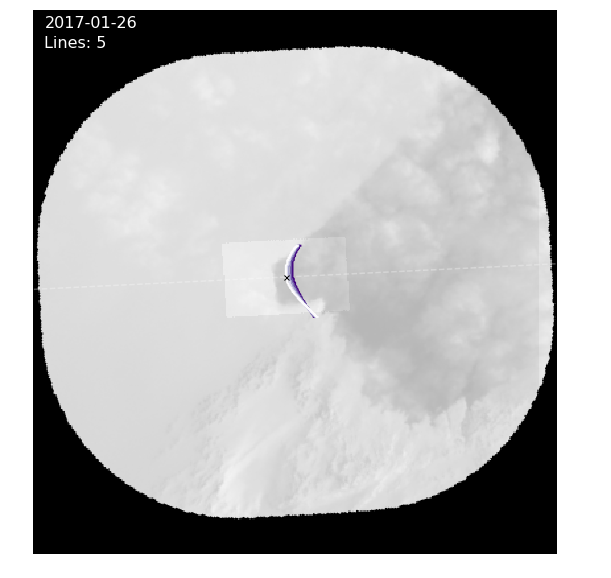

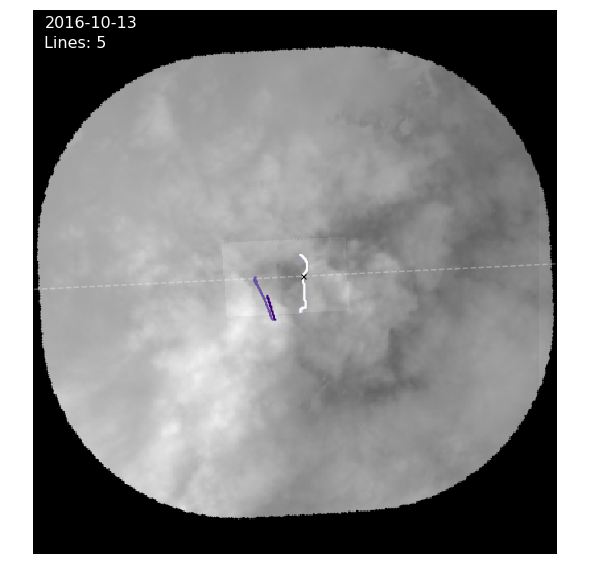

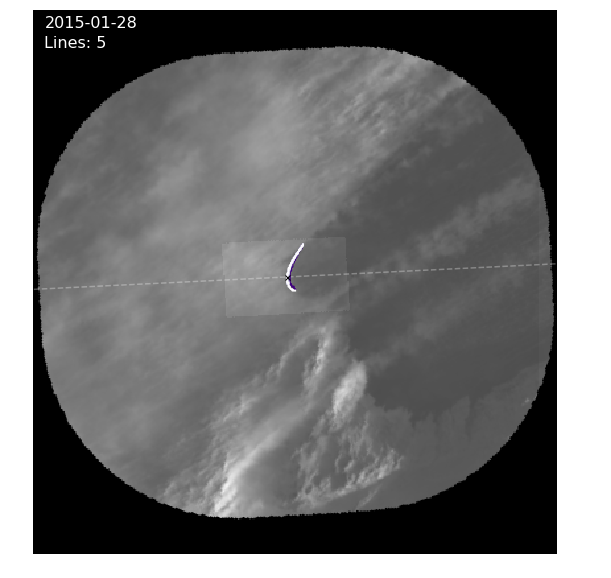

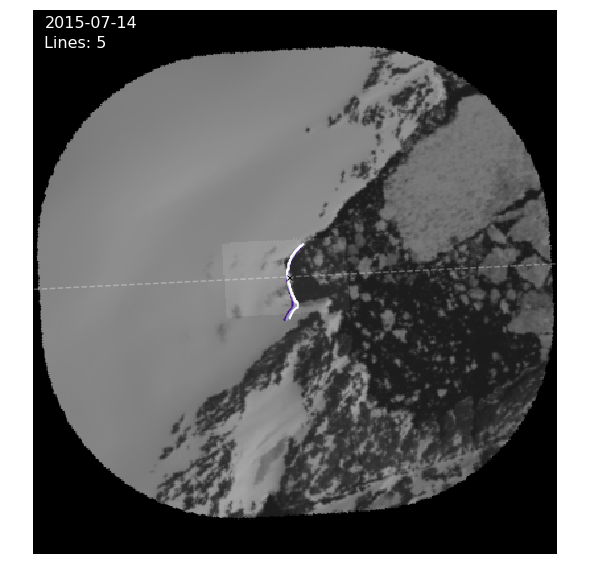

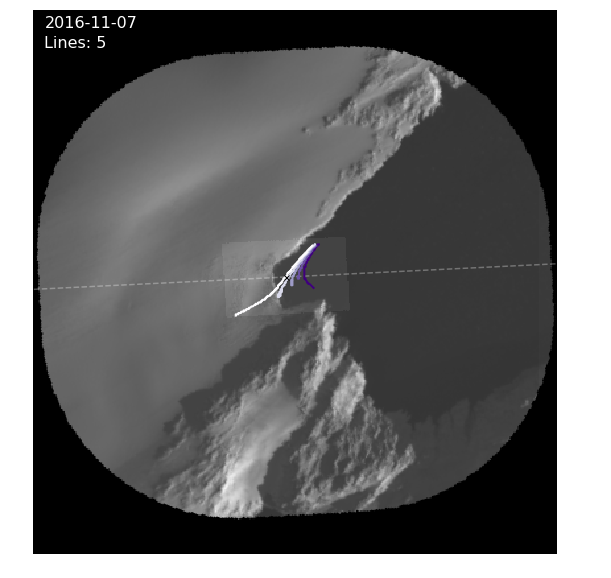

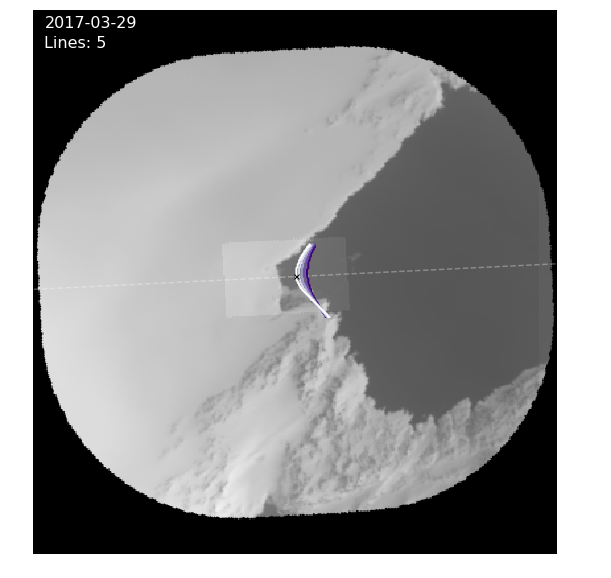

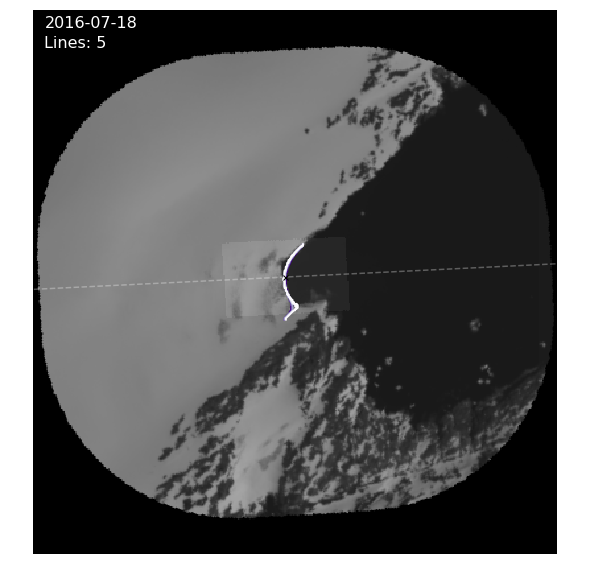

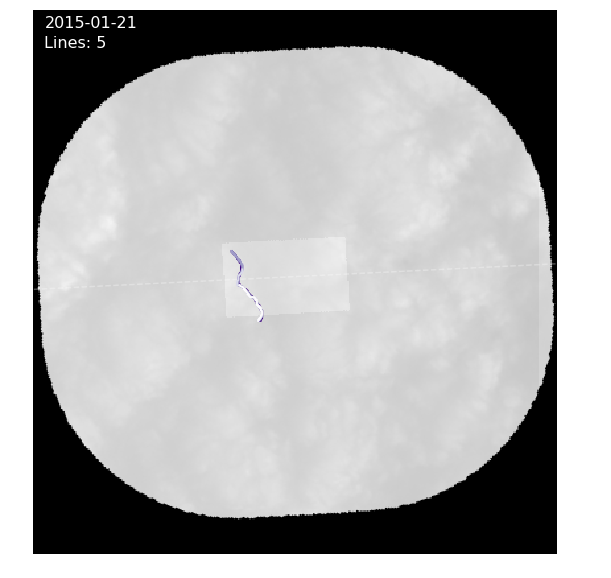

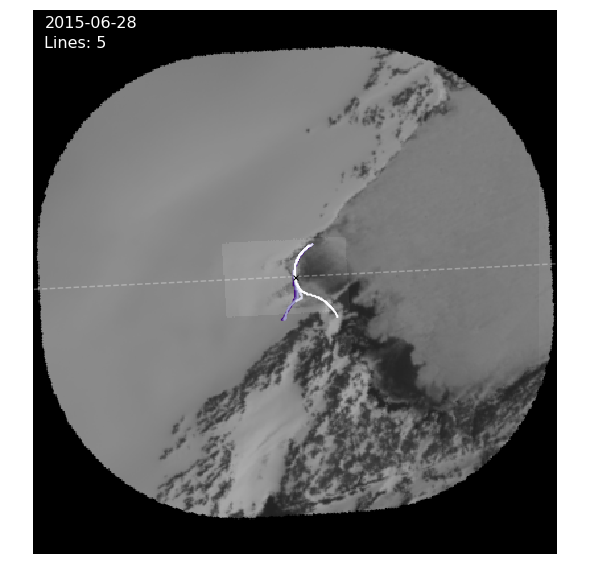

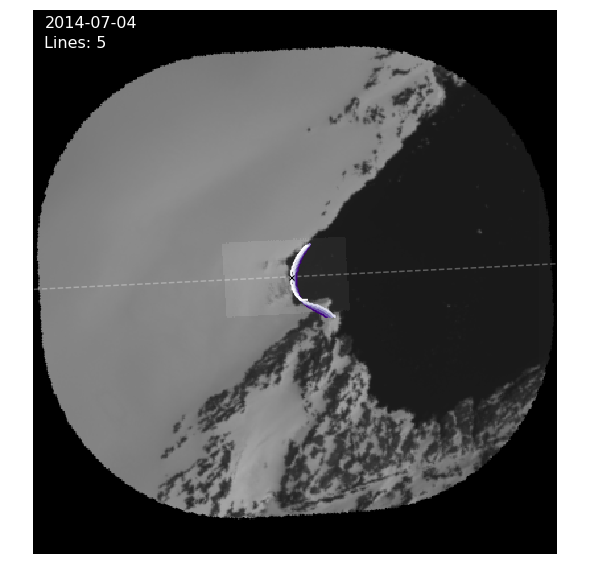

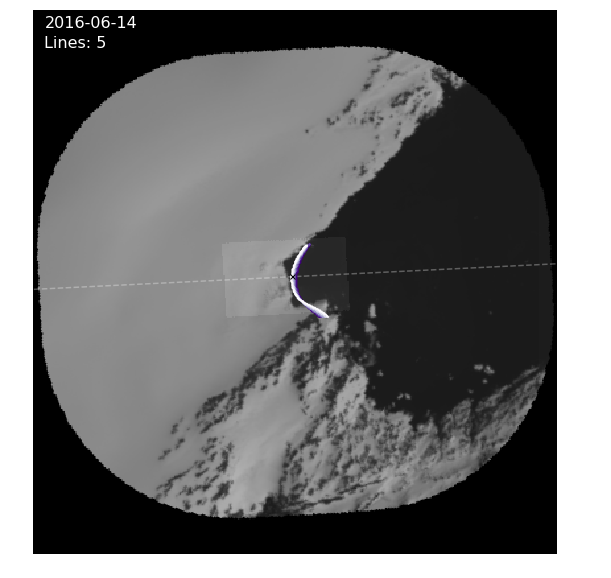

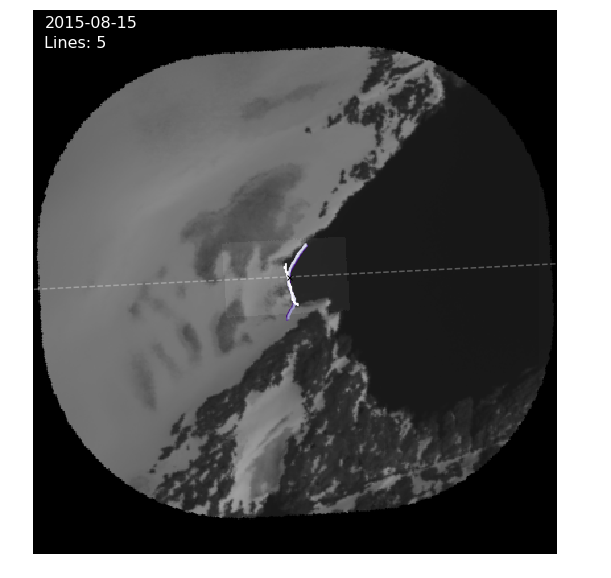

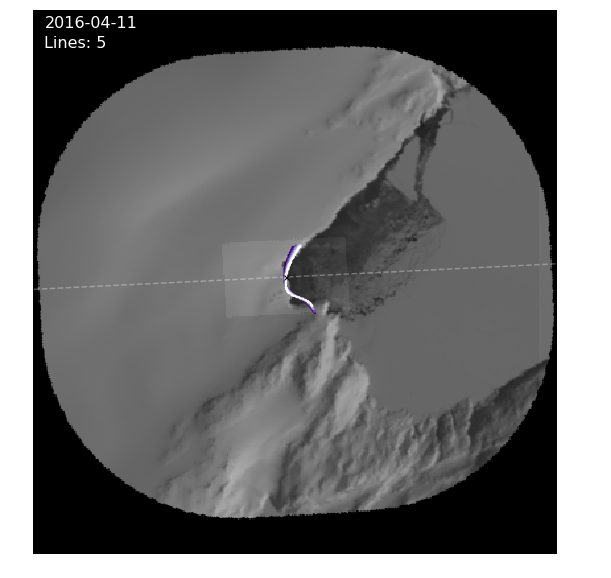

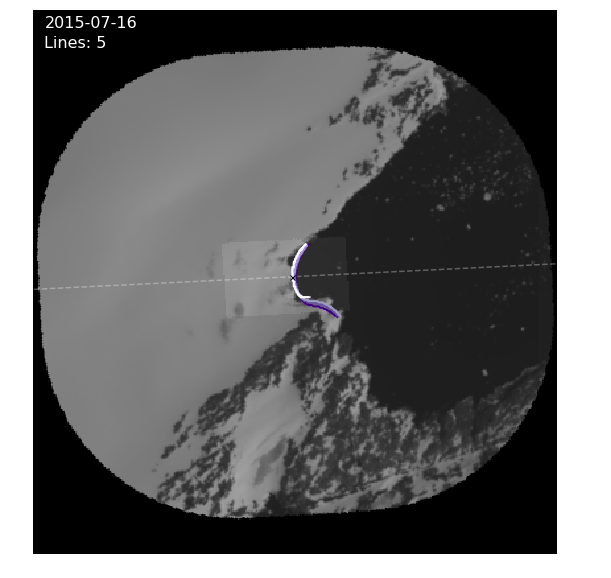

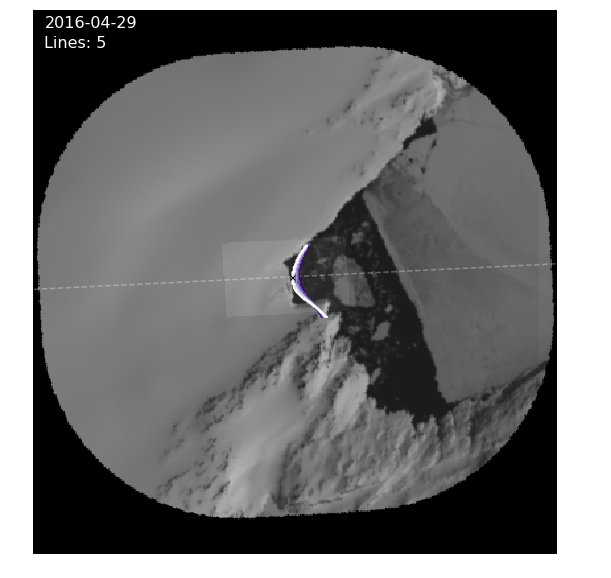

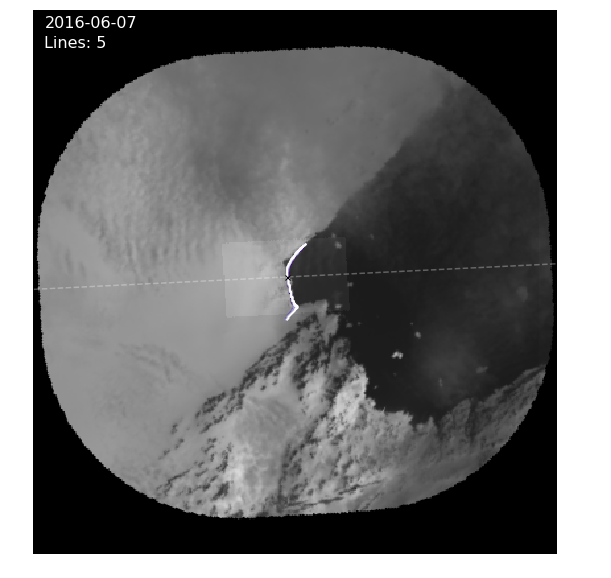

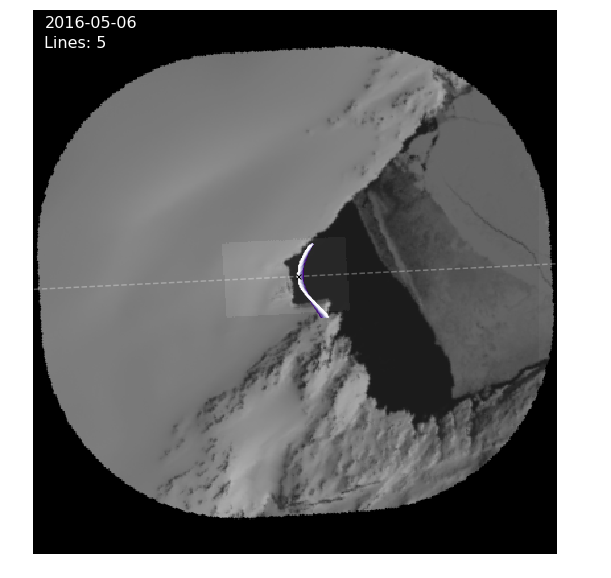

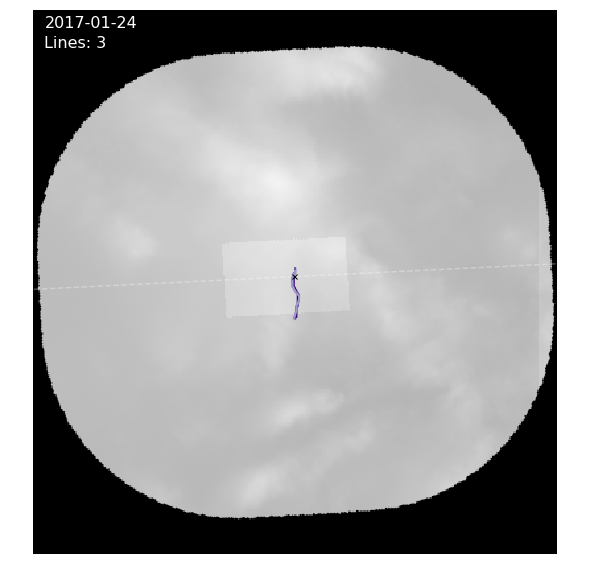

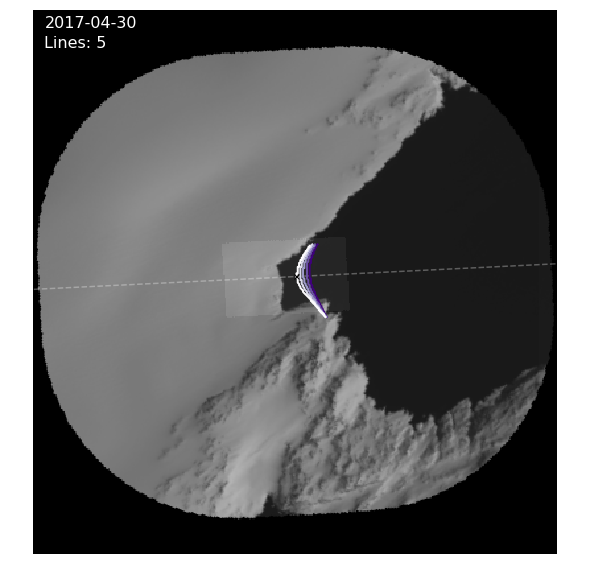

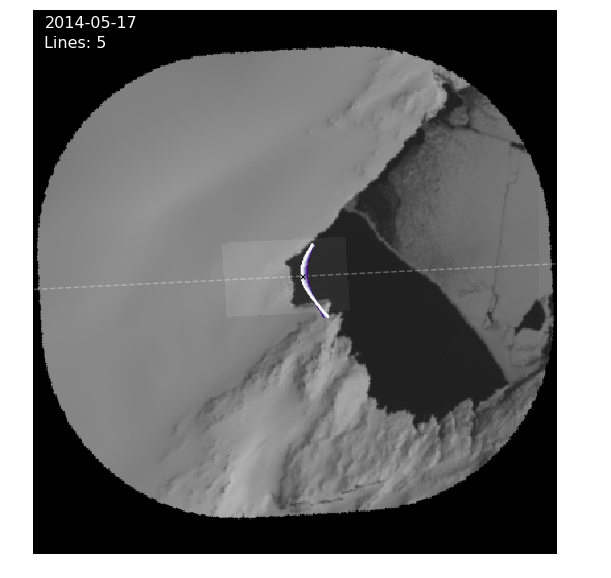

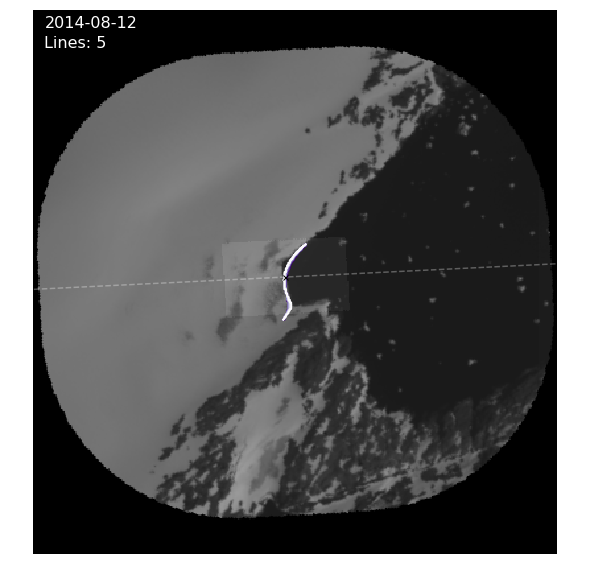

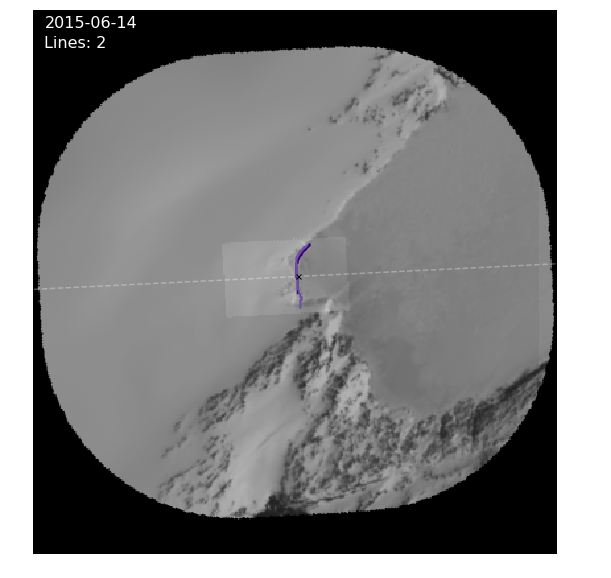

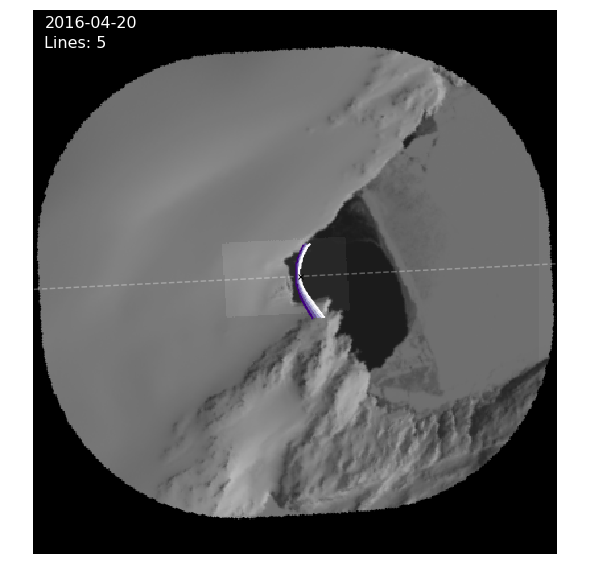

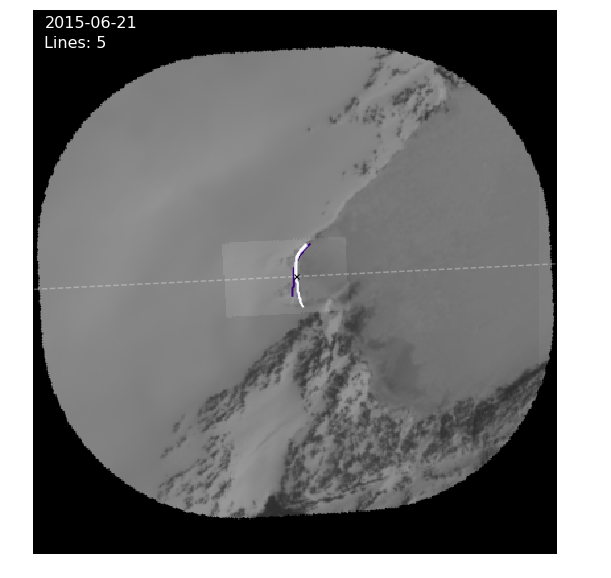

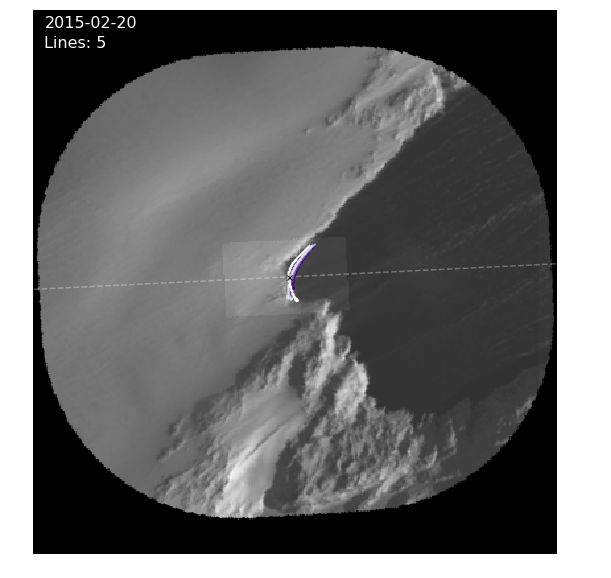

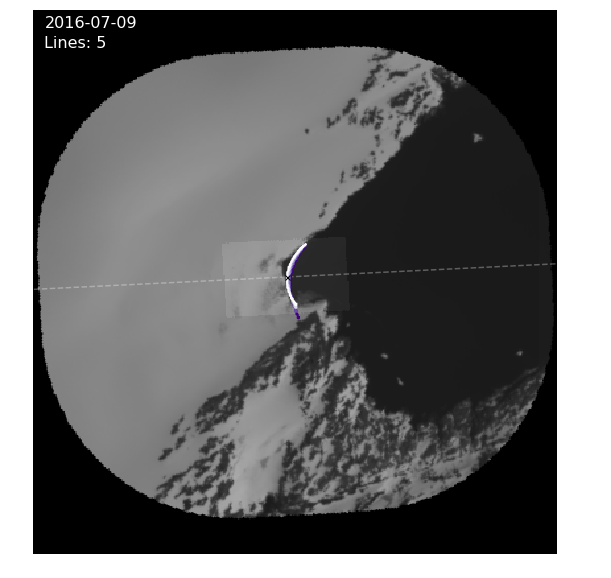

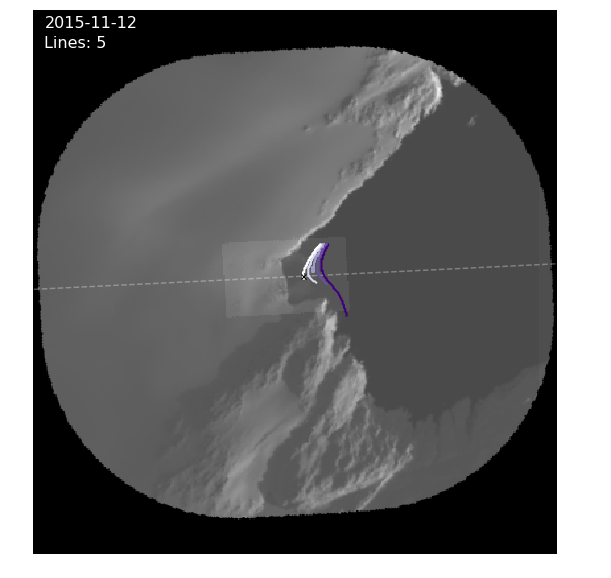

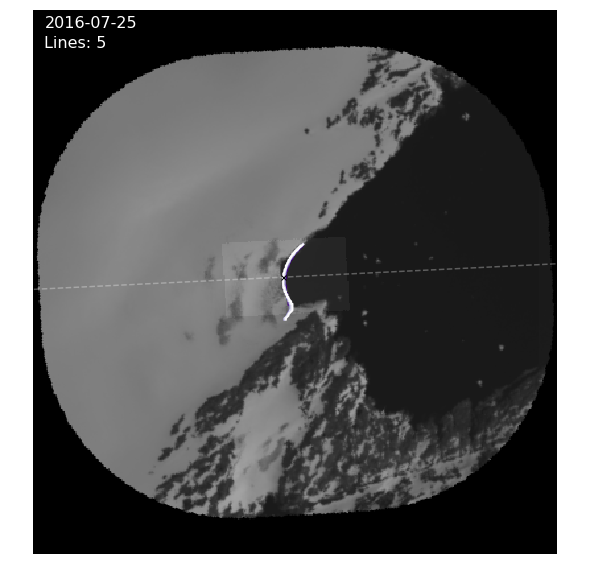

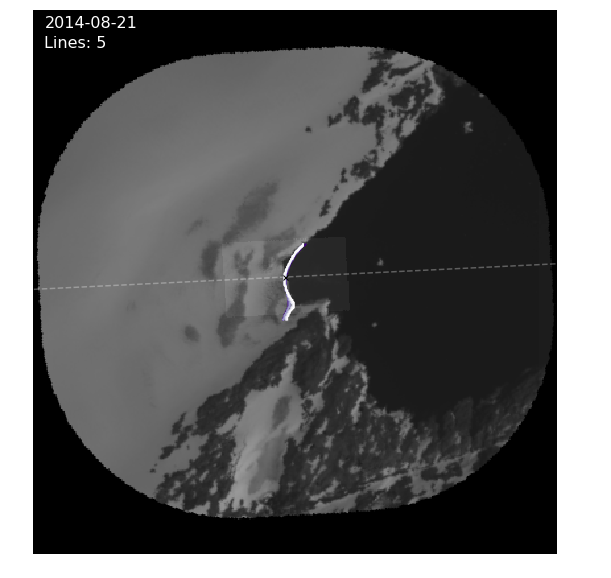

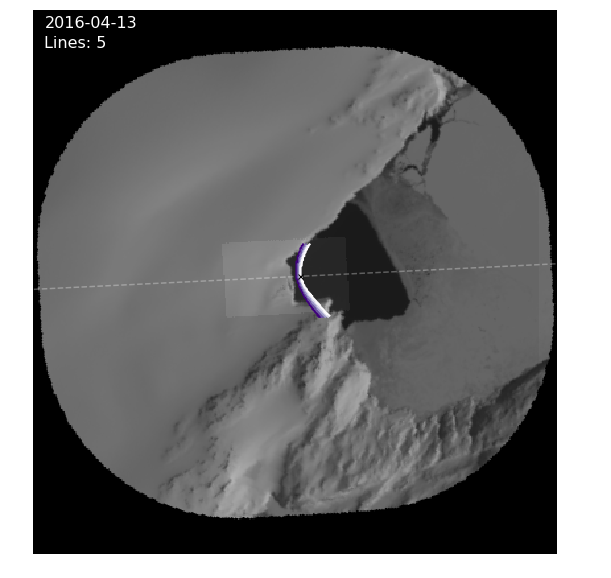

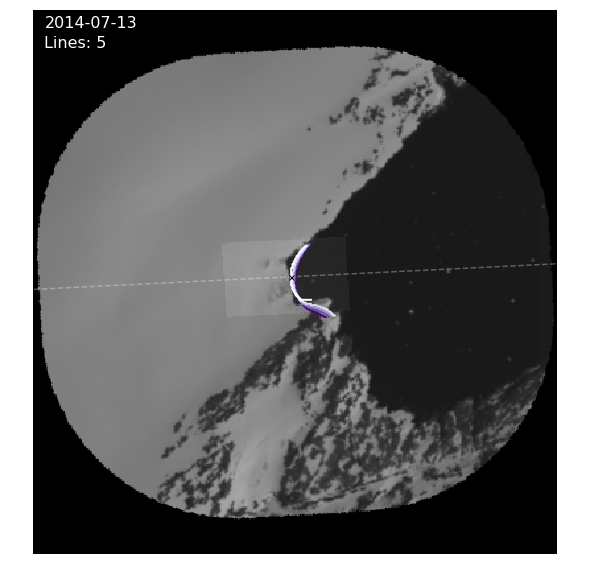

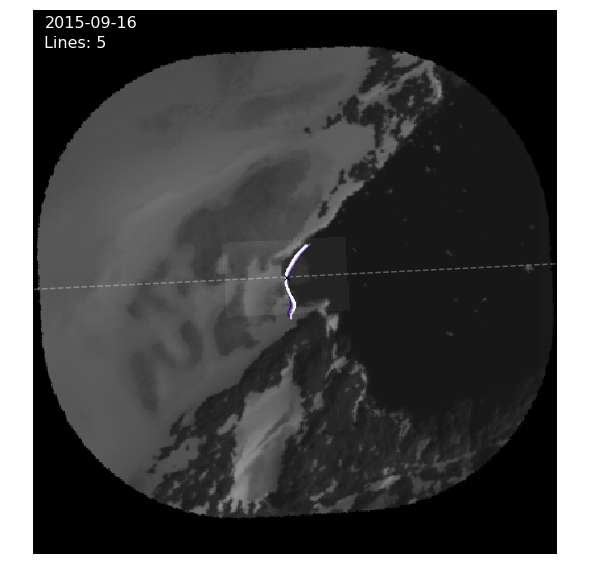

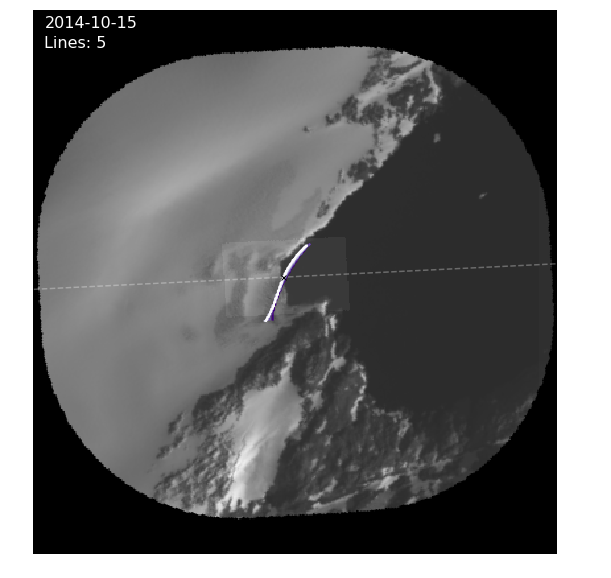

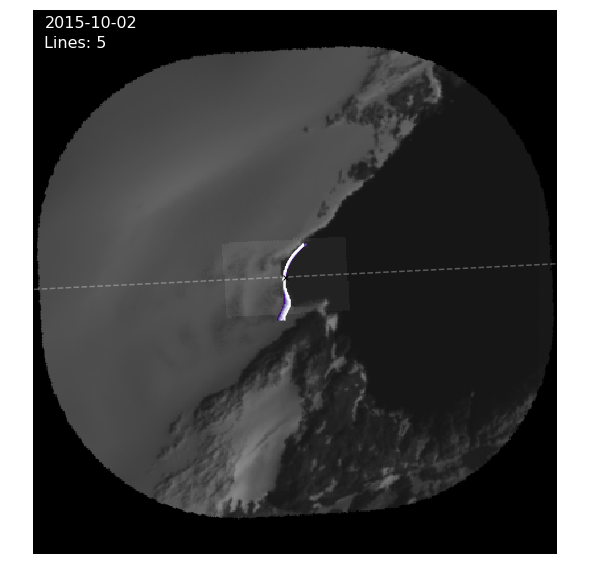

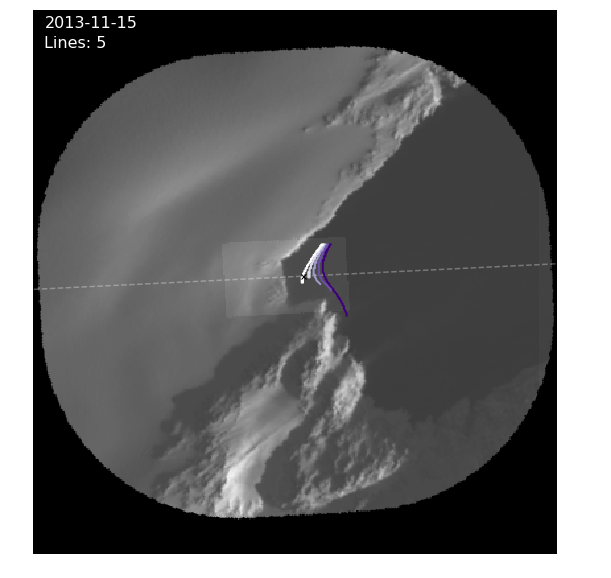

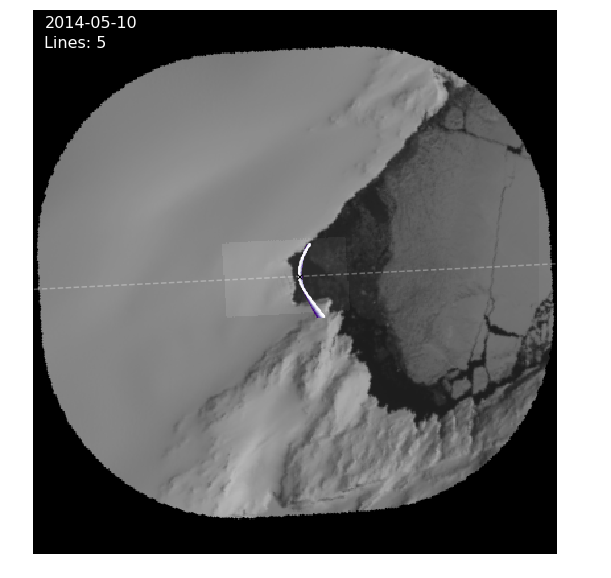

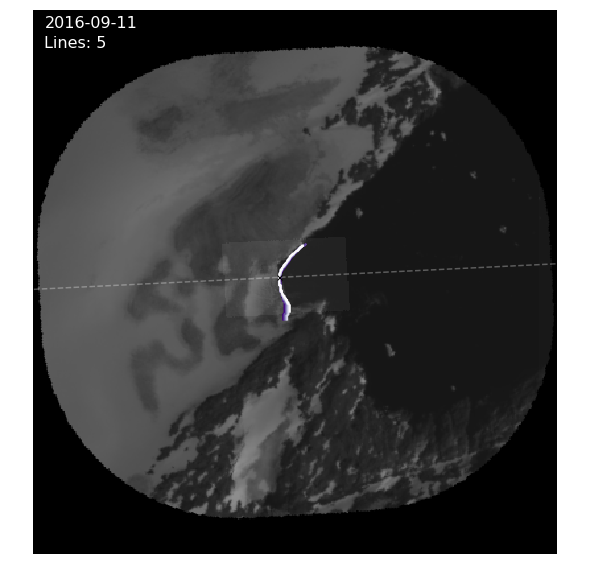

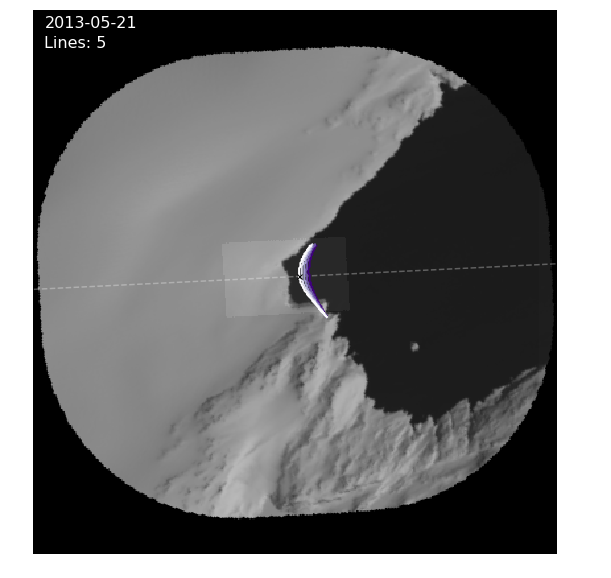

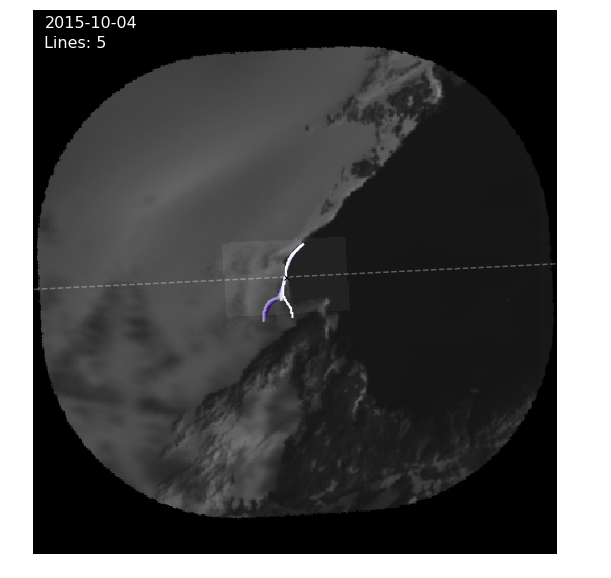

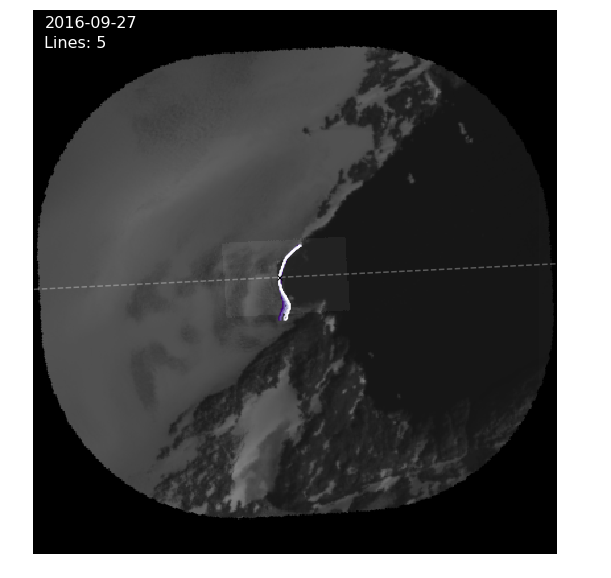

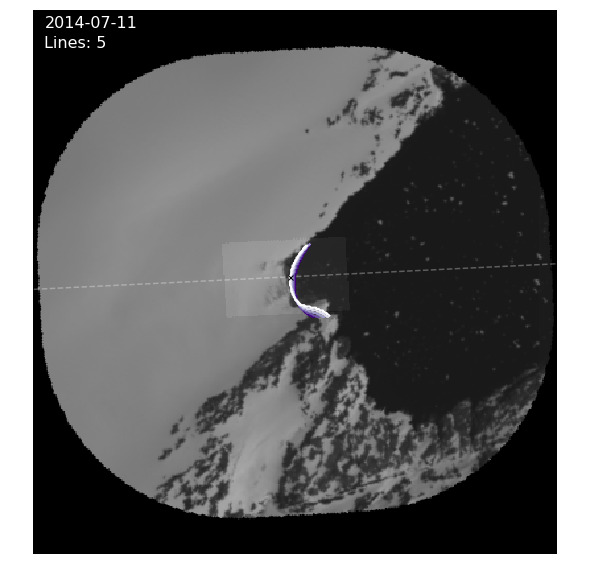

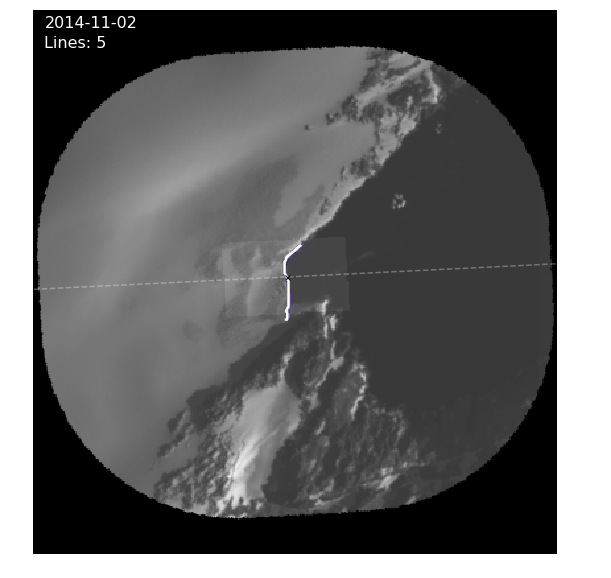

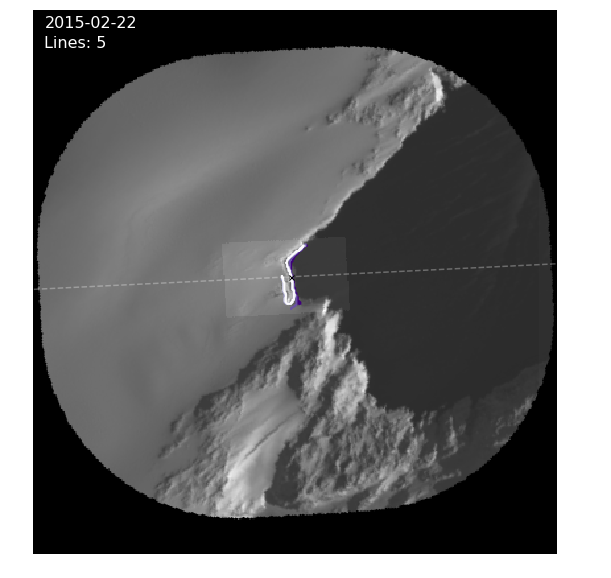

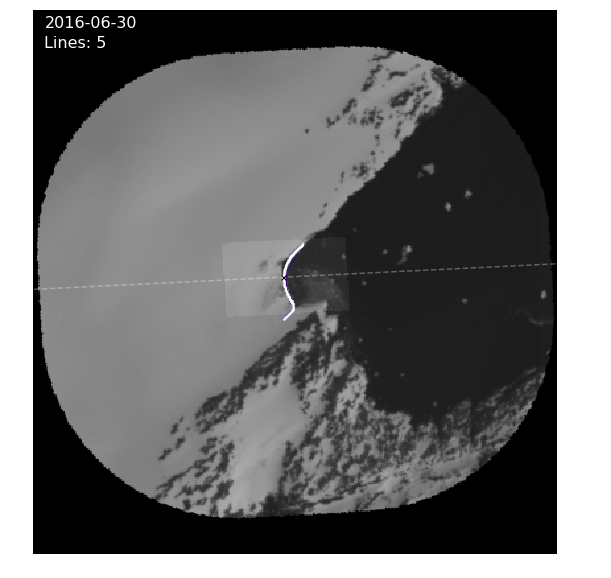

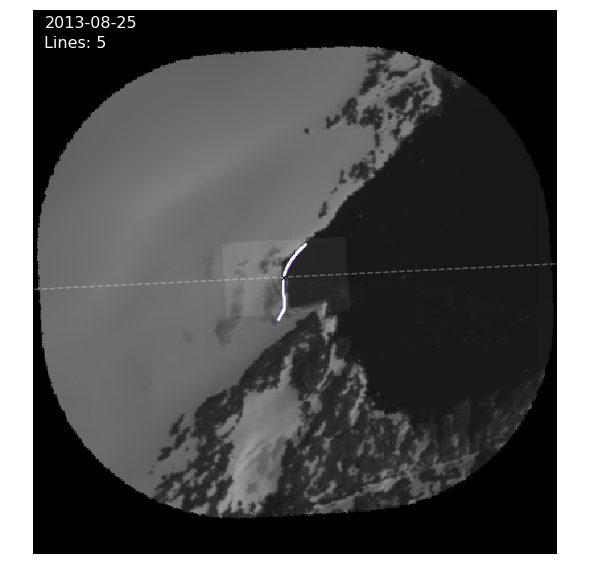

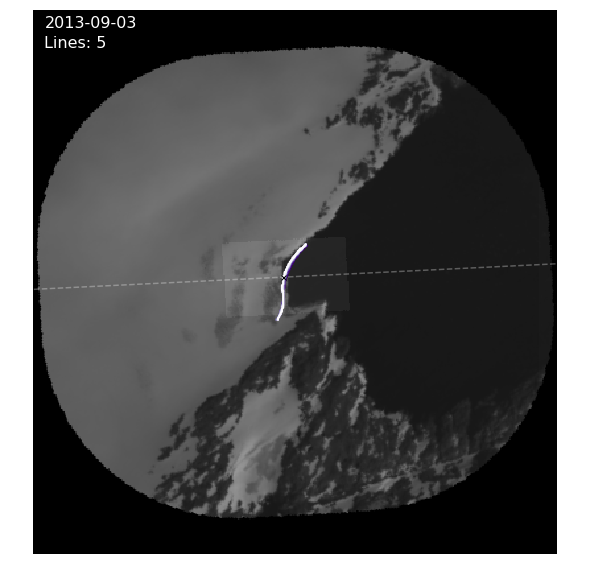

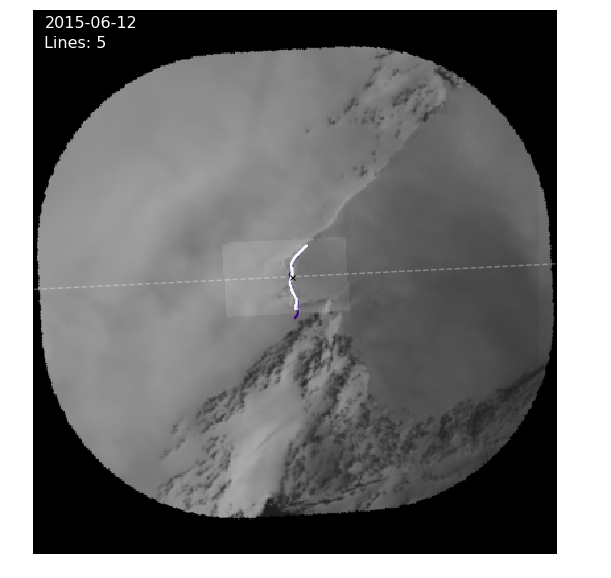

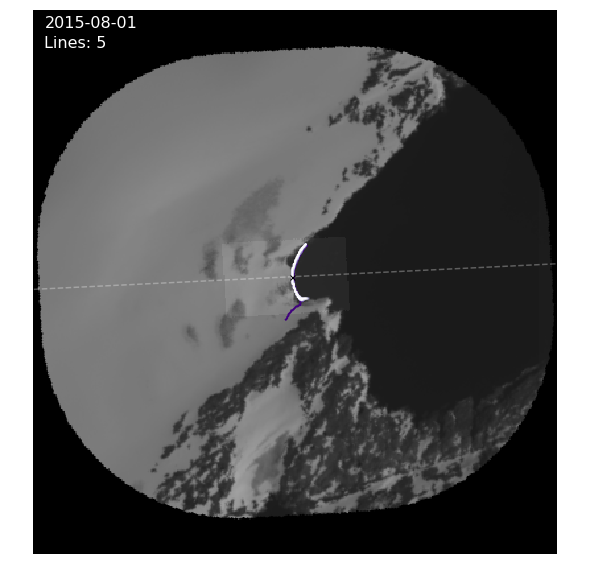

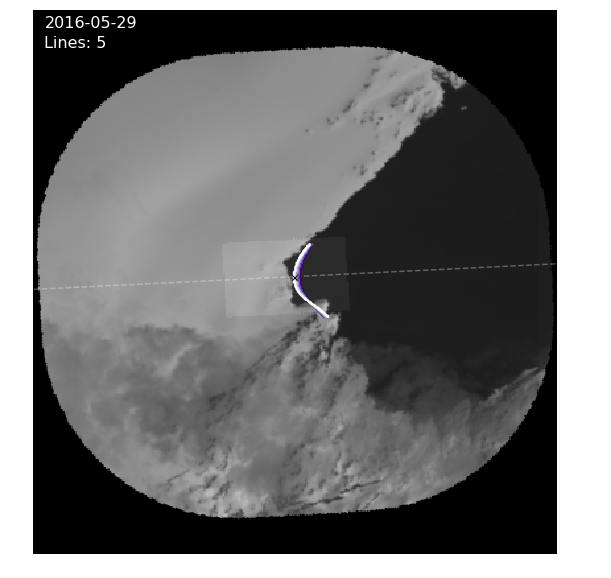

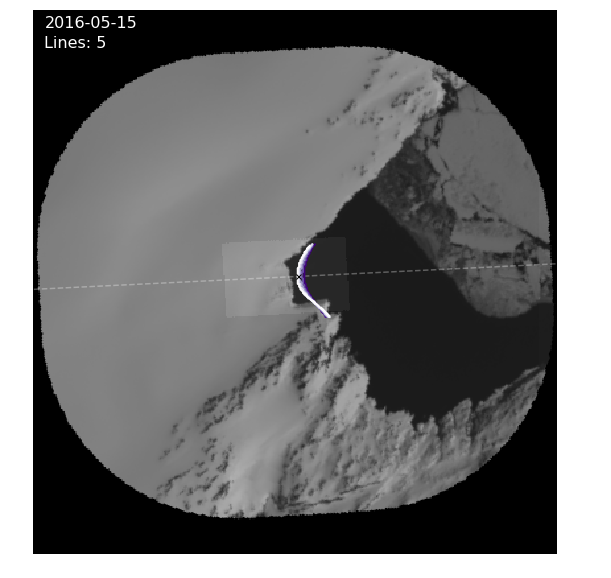

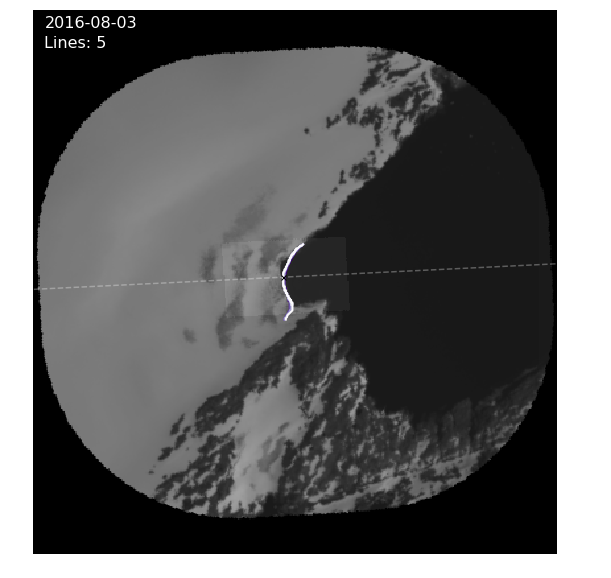

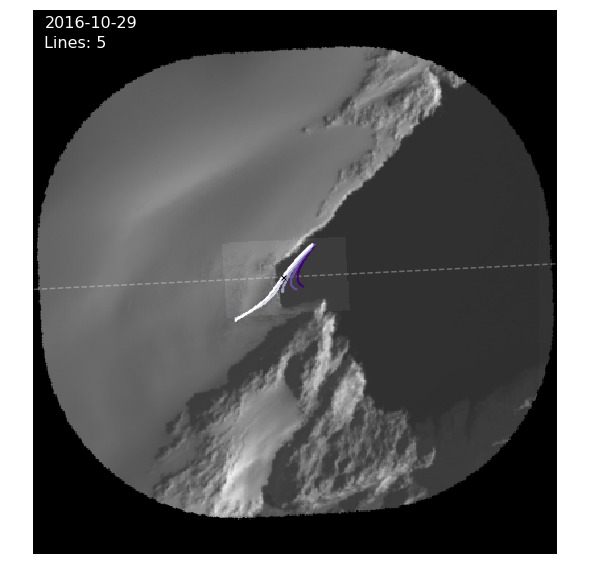

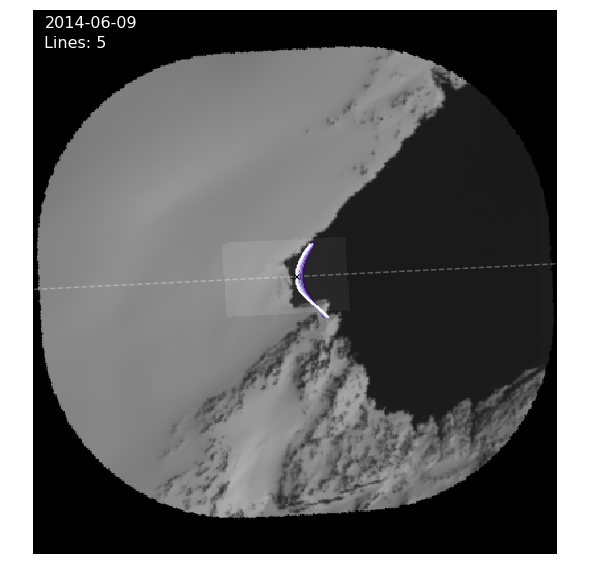

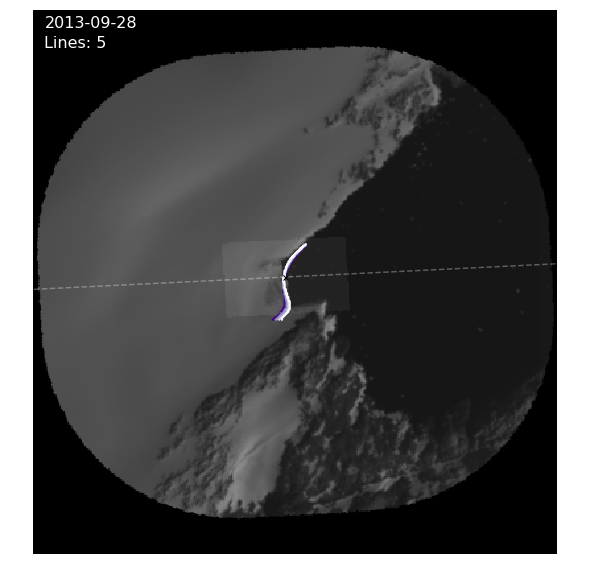

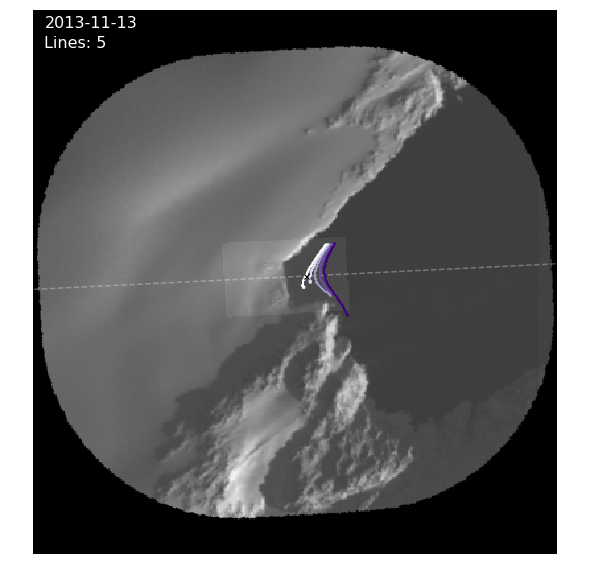

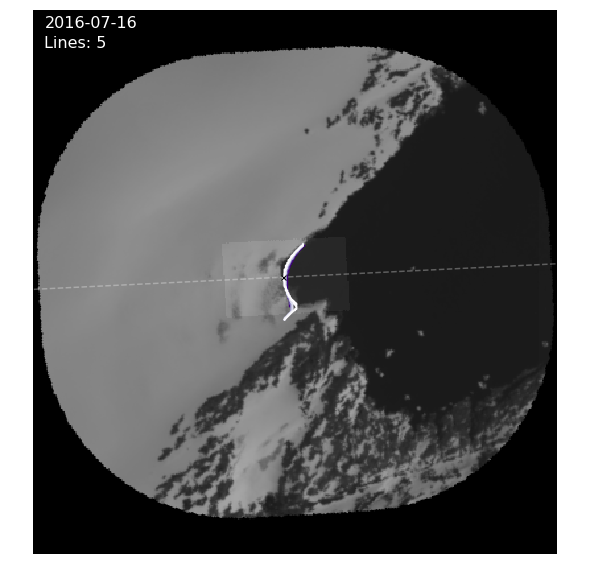

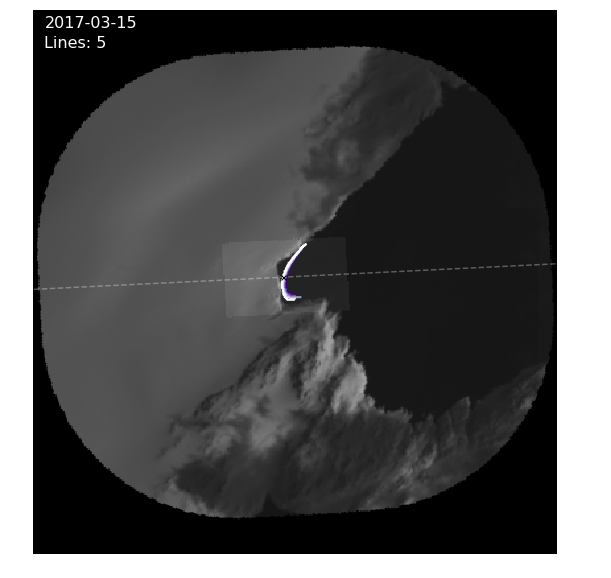

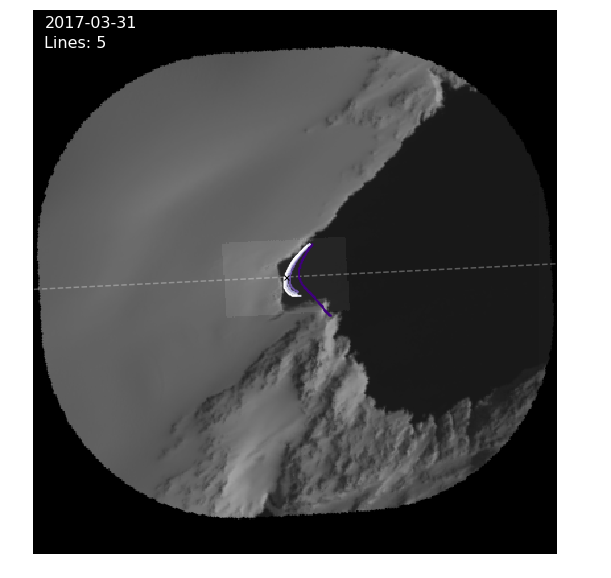

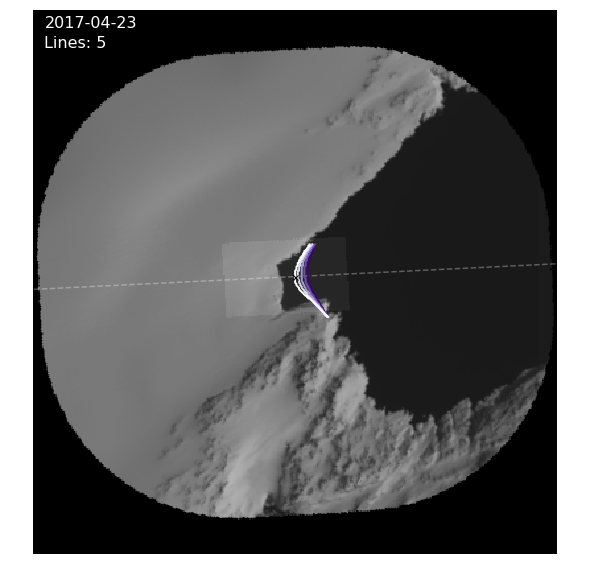

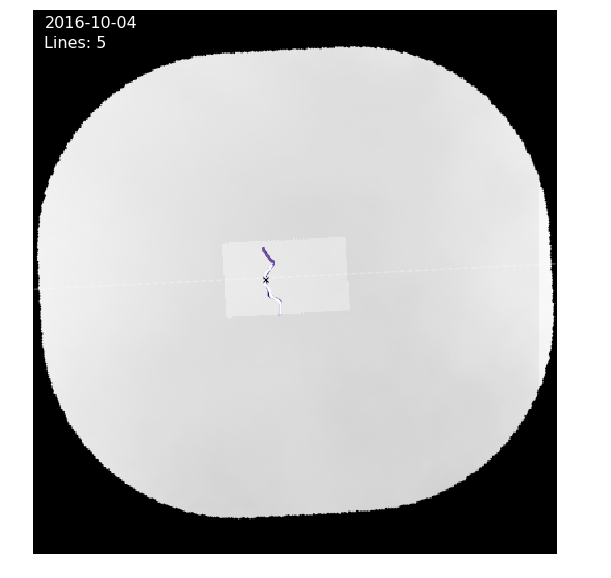

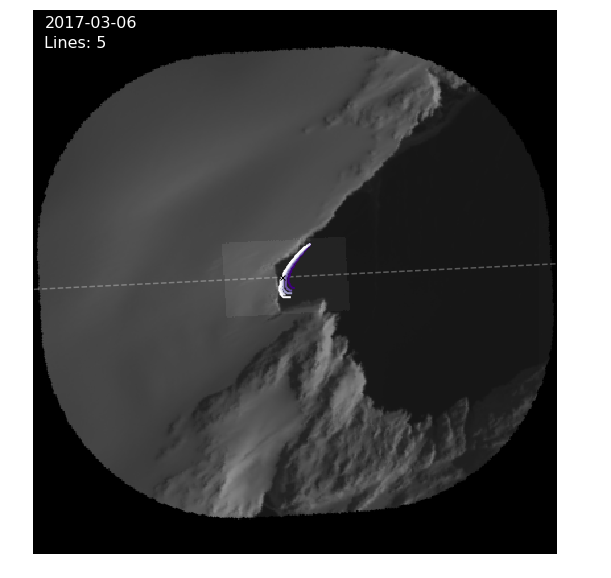

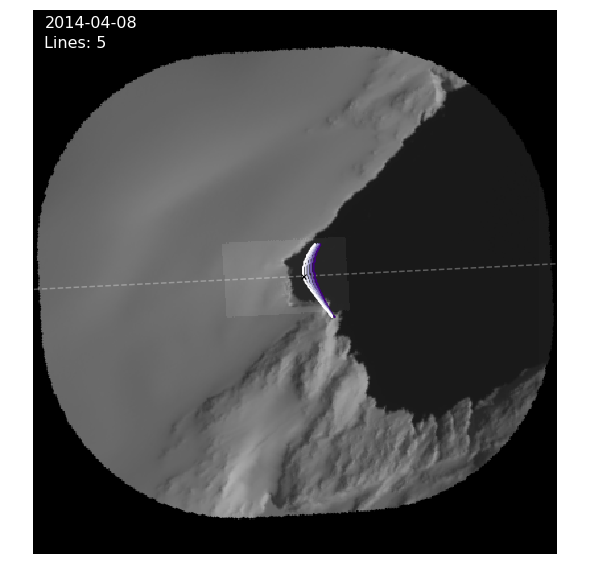

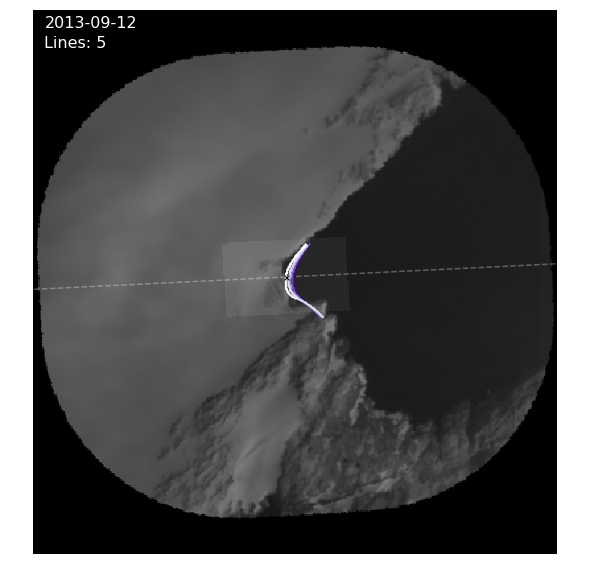

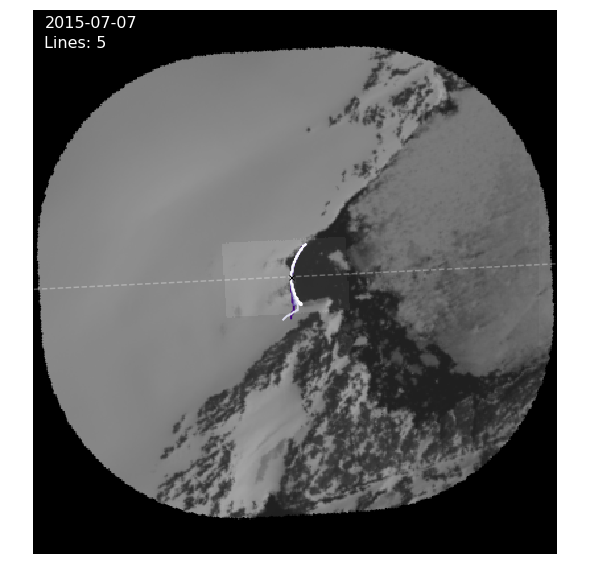

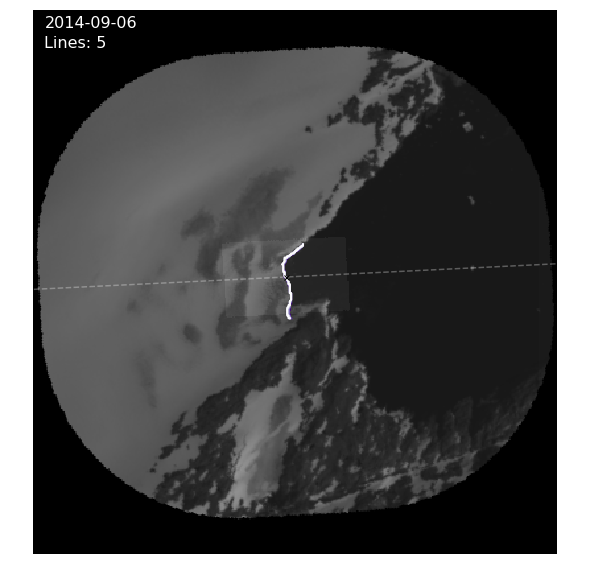

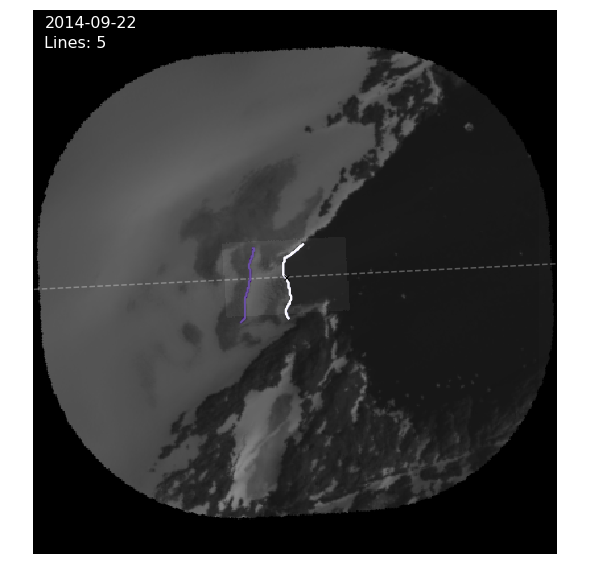

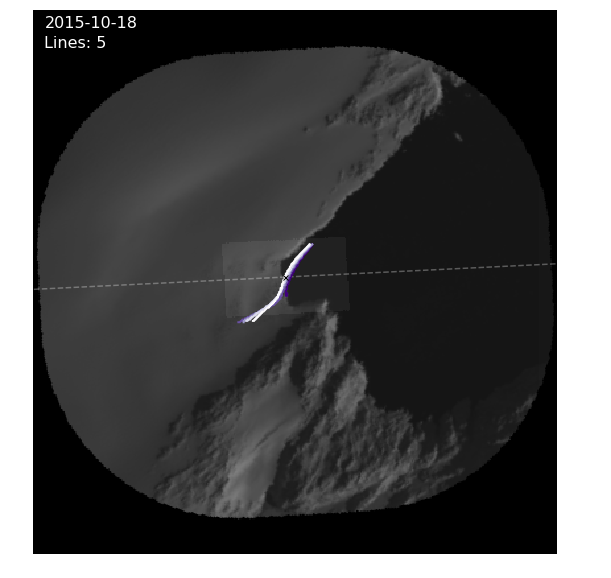

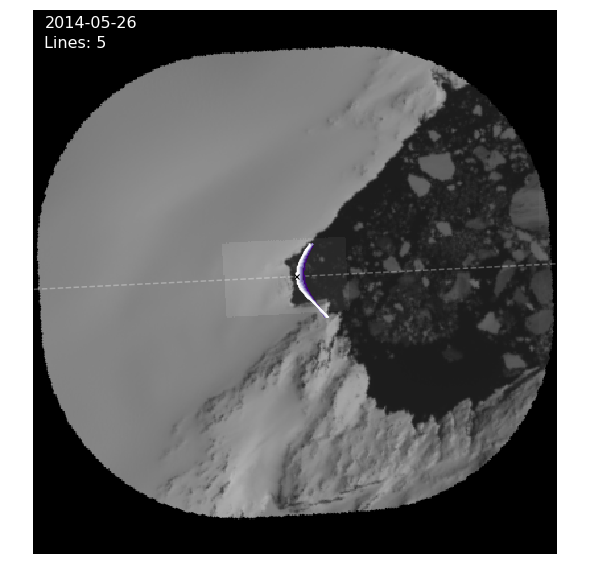

In [1068]:
# for index, row in dated_images_df.iterrows():
for scene in uniquescenes:    
    #separate the df by scene:
    scene_df = final_images_df[final_images_df['Scene'] == scene].copy()
    #sort by descending order so the worse orders are plotted first and the better orders are plotted on top
    scene_df = scene_df.sort_values(by='Order', ascending=False)
    
    #grab the date for the scene (just use the first since all should be the same)
    date = list(scene_df.datetimes)[0]
    
    #loop through the rows for each scene
    trimdatfiles = []
    datfiles = []
    orders = []
    
    for index, row in scene_df.iterrows():
        #grab the terminus_trim files and append to list
        trimdatfiles.append(row['Trimmed_dat_filename'])
        datfiles.append(row['Dat_filename'])
        #grab the order to be plotted later:
        orders.append(row['Order'])
        
#     print(scene, trimdatfiles)

    #Read in the image.png as np array
    image = mpimg.imread(imagepath+"crop_R_"+scene+"_B8_PS_Buffer"+BOI+'.png')
    
    #Read in terminus box raster as an np array
    tbox = mpimg.imread(csvpaths+"Box"+BOI+"/rotated_images/final/crop_Box"+BOI+"_raster_cut.png")
    
    #set path to that image's datfiles:
    datpath = imagepath+"crop_R_"+scene+"_B8_PS_Buffer"+BOI+".pgm_max_gaussian/"+metric
    
    #grab dat xs and ys
    datxs = {}
    datys = {}
    
    for i in range(0, len(trimdatfiles)):
        trimdat = trimdatfiles[i]
        dat = datfiles[i]
#         print(trimdat)
        #Read in dat file as np array and grab x and y values
        term_trim_dat = np.loadtxt(datpath+trimdat)
#         term_dat = np.loadtxt(datpath+dat)
#         print(term_trim_dat.shape)
        
        xs = []
        ys = []
        #grab x and y coordinates for the terminus line
        for j in term_trim_dat:
            x, y = (j[0], j[1])
            xs.append(x)
            ys.append(y)
        
        #update into dat xs and ys dictionaries:
        datxs.update({trimdat: xs})
        datys.update({trimdat: ys})
        
    #PLOT THE LANDSAT IMAGE and TERMINUS BOX
    plt.figure(figsize=(20,10))
    plt.axis("off")
    imgplt_trim = plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    boxplt = plt.imshow(tbox, alpha=0.05)
    
    #PLOT CENTERLINE
    #grab slope and intercept from the dataframe
    c_slope = float(centerline_df.loc[BOI]['cline_slope'])
    c_intercept = float(centerline_df.loc[BOI]['cline_intercept'])  
    #grab x values from width of the image:
    c_x = np.linspace(0,image.shape[0], image.shape[0])
    c_y = c_slope*c_x + c_intercept
    plt.plot(c_x, c_y, '--w', linewidth=1.5, alpha=0.3)

    #PLOT DATE in the top left corner
    plt.text(int(0.02*image.shape[0]), int(0.035*image.shape[1]), date, fontsize=16, color='w')
    
    #PLOT TOP PICK in purple
    toppick = trimdatfiles[len(trimdatfiles)-1]
#     toppick = datfiles[len(datfiles)-1]
#     plt.plot(datxs[toppick], datys[toppick], color='m')
    print(toppick)
    
    #PLOT ALL TOP PICKS in different shades of purple
    #create five shades for each order
    colors = pl.cm.Purples_r(np.linspace(0,1,5))
    col_count = 0
    #plot number of lines
    plt.text(int(0.02*image.shape[0]), int(0.07*image.shape[0]), "Lines: "+str(len(trimdatfiles)), fontsize=16, color='w')
    #plot each termline
    for line in trimdatfiles:
        #grab the x and y values for that termline
        x, y = datxs[line], datys[line]
        #plot with color scheme
        plt.plot(x, y, color=colors[col_count], linewidth=2)
        col_count = col_count+1
        
    #CALCULATE intersection of top pick with centerline and plot
#     intersect_x = []
#     intersect_y = []
    #switch to grab only 1 intersection, if you want to grab multiple uncomment all the intersect_found code
#     intersect_found = False
    intersect_xs = []
    intersect_ys = []
    
    #loop through all the x,y values in the terminus pick
    for j in range(0, len(c_x)):
        x = c_x[j]
        y = c_y[j]
        interval = 0.6
        for k in range(0, len(datxs[toppick])):
            dat_x = datxs[toppick][k]
            dat_y = datys[toppick][k]
            if within(dat_x, x, interval) and within (dat_y, y, interval): #and intersect_found == False:
                intersect_xs.append(dat_x)
                intersect_ys.append(dat_y)
#                 intersect_found = True

    #intersection with the greatest x
    if len(intersect_xs) > 0:
        max_index = intersect_xs.index(np.max(intersect_xs))
        intersect_x = intersect_xs[max_index]
        intersect_y = intersect_ys[max_index]

        plt.plot(intersect_x, intersect_y, 'kx', markersize='5')
 
    #SAVE AND DELAY
    plt.savefig(basepath+"Box"+BOI+"/Results/"+date+"_"+massorsize+"_trim_"+scene+".png", dpi=100, bbox_inches='tight')
#     plt.show()
    
#     sleep(2)
#     clear_output()
print("Done.")

## 3) Calculate terminus positions and terminus change rates by glacier

### Terminus position:

In [1047]:
#LOAD IN REFERENCE POINT to calculate terminus position with respect to
box_midpoint_x = np.float(centerline_df.loc[BOI, 'midpoint_x'])

#GRAB CENTERLINE POINTS
#grab slope and intercept from the dataframe
c_slope = float(centerline_df.loc[BOI]['cline_slope'])
c_intercept = float(centerline_df.loc[BOI]['cline_intercept'])  
#grab x values from width of the image:
c_x = np.linspace(0,image.shape[0], image.shape[0])
c_y = c_slope*c_x + c_intercept

#LISTS TO HOLD TERMINUS POSITIONS AND CHANGE RATES
terminus_positions = []

#sort the subset DataFrame by date of delineation from earliest to latest AND order
final_images_df = final_images_df.sort_values(by=['datetimes','Scene','Order'], ascending=True)

for index, row in final_images_df.iterrows():
    trimdat = row['Trimmed_dat_filename']
    dat = row['Dat_filename']
    scene = row['Scene']
    date = row['datetimes']
    
    #CALCULATE TERMINUS POSITION
    #load in dat files and calculate intersection points
    datpath = imagepath+"crop_R_"+scene+"_B8_PS_Buffer"+BOI+".pgm_max_gaussian/"+metric
    term_trimdat = np.loadtxt(datpath+trimdat)
    term_dat = np.loadtxt(datpath+dat)                          
    #intersect_x = None
    #intersect_y = None
    #intersect_found = False
    #multiple intersections:
    intersect_xs = []
    intersect_ys = []
    #loop through all the x,y values for the centerline
    for j in range(0, len(c_x)):
        x = c_x[j]
        y = c_y[j]
        interval = 0.6
        #where are the intersections with the terminus pick?
        for dat_x, dat_y in term_trimdat:
            if within(dat_x, x, interval) and within (dat_y, y, interval): #and intersect_found == False:
                #intersect_x = dat_x
                #intersect_y = dat_y
                #intersect_found = True
                intersect_xs.append(dat_x)
                intersect_ys.append(dat_y)
    
    if len(intersect_xs) > 0:
        #intersection with the greatest x
        max_index = intersect_xs.index(np.max(intersect_xs))
        intersect_x = intersect_xs[max_index]
        intersect_y = intersect_ys[max_index]
    
    #subtract intersection_x from the box_midpoint_x to get terminus position in meters
    if len(intersect_xs) == 0:
        term_position = np.NaN
    else:
        term_position = (intersect_x - box_midpoint_x)*15.0
    terminus_positions.append(term_position)
    
# ADD TERMINUS POSITION AND CHANGERATES BACK INTO THE DATAFRAME
final_images_df['term_position'] = terminus_positions

### Terminus change rates (m/d)

#### Convert dates into datetime objects for rate calculations and timeseries plotting

In [1048]:
#Turn datetimes from datetime_df into DateTime objects
#grab the datetime strings
datetimes = final_images_df.loc[:,'datetimes']
#create list to store the datetime objects
datetime_objs = []

for date in datetimes:
    date = str(date)
    datetime_obj = datetime.datetime.strptime(date, '%Y-%m-%d')
    datetime_obj = np.datetime64(datetime_obj)
    datetime_objs.append(datetime_obj)

#add the datetime objects back into the datetime column
final_images_df['datetimes'] = datetime_objs

In [1049]:
terminus_changerates = []

#drop NaNs:
final_images_df = final_images_df.dropna()

for i in range(0, len(final_images_df.index)):
    date = list(final_images_df['datetimes'])[i]
    term_position = list(final_images_df['term_position'])[i]
    scene = list(final_images_df['Scene'])[i]
    
    #CALCULATE TERMINUS CHANGE RATE
    #grab the earliest date
    earliestdate = list(final_images_df['datetimes'])[0]
    #for the first date, the changerate is nan
    if date == earliestdate:
        changerate = np.NaN
    #for all other subsequent entries:
    else:
        #grab current date and terminus position
        t = date
        x = term_position
        
        #grab previous date of analysis 
        counter = 1
        t_prev = list(final_images_df['datetimes'])[i-counter]
        while t_prev == t:
            counter = counter+1
            t_prev = list(final_images_df['datetimes'])[i-counter]
        
        #grab all terminus positions from previous date of analysis:
        prev_df = final_images_df[final_images_df['datetimes'] == t_prev].copy()
        #grab the one that corresponds to the highest order
        highestorder = np.min(np.array(prev_df['Order']))
        if len(prev_df[prev_df['Order']==highestorder].term_position) > 1:
            x_prev = float(list(prev_df[prev_df['Order']==highestorder].term_position)[0])
        else:
            x_prev = float(prev_df[prev_df['Order']==highestorder].term_position)
                
        #calculate terminus change (m)
        delta_x = x - x_prev
        #calculate time change (days)
        delta_t = t - t_prev
        delta_t = delta_t.days
        
        #Calculate change rate!
        changerate = delta_x/delta_t
    
    terminus_changerates.append(changerate)

final_images_df['changerate'] = terminus_changerates
print(len(terminus_changerates))

958


## 4) Plot terminus position (highest order) and change rate timeseries

## Filtering using max flow speeds:

In [1050]:
#Grab max flow threshold from glacier velocities in flowspeed_df
max_flow = float(flowspeed_df['Max_speed'][BOI])
if max_flow < 1.0:
    flow_thresh = 5.0
else:
    flow_thresh = 5.0*max_flow
print(flow_thresh)

5.0


In [1051]:
#REMOVE DIPS
dip_indices = []

#reset index for final_images_df
final_images_df = final_images_df.reset_index(drop=True)
# for index, row in onepick_df.iterrows():
for index, row in final_images_df.iterrows():
    rate = row['changerate']
    date = row['datetimes']
    #for negative change rates:
    if rate < 0:
        #make the threshold negative
        flow_thresh = -flow_thresh
        #if it's unrealistic (faster than threshold)
        if rate < flow_thresh:
            #check the next entry only if it's in the range of indices
#             if index+1 < len(onepick_df.index):
            if index+1 < len(final_images_df.index):
                nextrate = final_images_df.loc[index+1]['changerate']
                #if it's a sudden jump, then we have found a dip. Remove it
                if nextrate > abs(flow_thresh):
                    dip_indices.append(index)

print(dip_indices)
filtered_df = final_images_df.drop(dip_indices)

[40, 63, 178, 234, 267, 270, 292, 322, 331, 398, 416, 438, 453, 468, 529, 576, 579, 581, 595, 631, 640, 652, 655, 706, 719, 733, 738, 763, 790, 798, 808, 818, 828, 861, 877, 915, 922, 925, 931]


In [1052]:
#RECALCULATE TERMINUS CHANGE RATES
terminus_changerates = []

for i in range(0, len(filtered_df.index)):
    date = list(filtered_df['datetimes'])[i]
    term_position = list(filtered_df['term_position'])[i]
    
    #CALCULATE TERMINUS CHANGE RATE
    #grab the earliest date
    earliestdate = list(filtered_df['datetimes'])[0]
    #for the first date, the changerate is nan
    if date == earliestdate:
        changerate = np.NaN
    #for all other subsequent entries:
    else:
        #grab current date and terminus position
        t = date
        x = term_position
        
        #grab previous date of analysis and previous term position
        t_prev = list(filtered_df['datetimes'])[i-1]
        x_prev = list(filtered_df['term_position'])[i-1]
                
        #calculate terminus change (m)
        delta_x = x - x_prev
        #calculate time change (days)
        delta_t = t - t_prev
        delta_t = delta_t.days
        
        #Calculate change rate!
        if delta_t == 0:
            changerate = 0
        else:
            changerate = delta_x/delta_t
    
    terminus_changerates.append(changerate)
#     print(changerate)

filtered_df['changerate'] = terminus_changerates

In [1053]:
#FILTER unrealistic advances
jump_indices = []

for i in range(0, len(filtered_df.index)):
    date = list(filtered_df['datetimes'])[i]
    rate = list(filtered_df['changerate'])[i]
    index = list(filtered_df.index)[i]
 
    if rate > abs(flow_thresh):
        #remove it:
        jump_indices.append(index)
    
    #remove drops if they are due to first value for the season
    prev_date = list(filtered_df['datetimes'])[i-1]
    delta_date = date - prev_date
    delta_date = delta_date.days
            
    #if the time jump is more than 2, remove it.
    if delta_date > 60:
        jump_indices.append(index)
print(jump_indices)

filtered2_df = filtered_df.drop(jump_indices)

[39, 41, 59, 64, 69, 74, 79, 114, 179, 181, 201, 235, 240, 253, 263, 268, 293, 323, 332, 379, 399, 404, 419, 432, 439, 454, 469, 484, 504, 509, 514, 524, 526, 530, 535, 557, 567, 577, 582, 617, 632, 653, 707, 720, 725, 730, 734, 759, 764, 769, 774, 799, 809, 810, 819, 829, 834, 849, 854, 868, 878, 893, 898, 918, 923]


In [1054]:
filtered2_df.shape

(854, 11)

Grab only those terminus positions corresponding to the highest order terminus pick.

In [1055]:
#grab unique dates
unique_dates = set(list(filtered2_df['datetimes']))
print(len(unique_dates))
#grab highest order:
order_list = []
for date in unique_dates:
    date_df = filtered2_df[filtered2_df['datetimes'] == date].copy()
    highestorder = np.min(np.array(date_df['Order']))
    order_list.append(highestorder)

#create highestorder_df
highestorder_df = pd.DataFrame(list(zip(unique_dates, order_list)), columns=['datetimes', 'Order'])
highestorder_df = highestorder_df.sort_values(by='datetimes', ascending=True)
highestorder_df.head()

195


datetimes Order
124 2013-04-23     1
114 2013-04-25     1
12  2013-04-28     1
159 2013-05-02     1
191 2013-05-04     1

Inner merge with final_images_df to only keep those of the highest order

In [1056]:
onepick_df = filtered2_df.merge(highestorder_df, how='inner', on=['datetimes', 'Order'])
print(onepick_df.shape[0])
onepick_df

199


Scene BoxID  \
0    LC80130022013113LGN01   531   
1    LC80110022013115LGN01   531   
2    LC80160012013118LGN01   531   
3    LC80120022013122LGN01   531   
4    LC80100022013124LGN01   531   
5    LC80080022013142LGN01   531   
6    LC80130022013145LGN00   531   
7    LC80110022013147LGN00   531   
8    LC80120022013234LGN00   531   
9    LC80100022013236LGN00   531   
10   LC80110022013243LGN00   531   
11   LC80110022013259LGN00   531   
12   LC80090022013261LGN00   531   
13   LC80160012013262LGN00   531   
14   LC80080022013270LGN00   531   
15   LC80060032013272LGN00   531   
16   LC80150012014082LGN00   531   
17   LC80060032014083LGN00   531   
18   LC80090022014088LGN00   531   
19   LC80160012014089LGN00   531   
20   LC80100022014095LGN00   531   
21   LC80130022014100LGN00   531   
22   LC80090022014104LGN00   531   
23   LC80160012014105LGN00   531   
24   LC80070032014106LGN00   531   
25   LC80140012014123LGN00   531   
26   LC80160012014137LGN00   531   
27   LC80140012014139LGN00   531   
28   LC80100022014143LGN00   531   
29   LC80060032014147LGN00   531   
..                     ...   ...   
169  LC80080022016263LGN00   531   
170  LC80150012016264LGN00   531   
171  LC80060032016265LGN00   531   
172  LC80110022016268LGN00   531   
173  LC80090022016270LGN00   531   
174  LC80080022017073LGN00   531   
175  LC80060032017075LGN00   531   
176  LC80130022017076LGN00   531   
177  LC80110022017078LGN00   531   
178  LC80070032017082LGN00   531   
179  LC80140012017083LGN00   531   
180  LC80120022017085LGN00   531   
181  LC80100022017087LGN00   531   
182  LC80080022017089LGN00   531   
183  LC80060032017091LGN00   531   
184  LC80110022017094LGN00   531   
185  LC80090022017096LGN00   531   
186  LC80070032017098LGN00   531   
187  LC80140012017099LGN00   531   
188  LC80120022017101LGN00   531   
189  LC80100022017103LGN00   531   
190  LC80080022017105LGN00   531   
191  LC80060032017107LGN00   531   
192  LC80130022017108LGN00   531   
193  LC80110022017110LGN00   531   
194  LC80090022017112LGN00   531   
195  LC80160012017113LGN00   531   
196  LC80070032017114LGN00   531   
197  LC80140012017115LGN00   531   
198  LC80100022017119LGN00   531   

                                           Image_array      Dat_filename  \
0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_003.dat   
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_003.dat   
5    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
6    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
7    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_002.dat   
8    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
9    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
10   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
11   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_003.dat   
12   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
13   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_017.dat   
14   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_009.dat   
15   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_006.dat   
16   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_007.dat   
17   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_001.dat   
18   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
19   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
20   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
21   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  terminus_000.dat   
22   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

Re-calculate and filter again for unrealistic advances:

In [1057]:
#RECALCULATE TERMINUS CHANGE RATES
terminus_changerates = []

for i in range(0, len(onepick_df.index)):
    date = list(onepick_df['datetimes'])[i]
    term_position = list(onepick_df['term_position'])[i]
    
    #CALCULATE TERMINUS CHANGE RATE
    #grab the earliest date
    earliestdate = list(onepick_df['datetimes'])[0]
    #for the first date, the changerate is nan
    if date == earliestdate:
        changerate = np.NaN
    #for all other subsequent entries:
    else:
        #grab current date and terminus position
        t = date
        x = term_position
        
        #grab previous date of analysis and previous term position
        t_prev = list(filtered_df['datetimes'])[i-1]
        x_prev = list(filtered_df['term_position'])[i-1]
                
        #calculate terminus change (m)
        delta_x = x - x_prev
        #calculate time change (days)
        delta_t = t - t_prev
        delta_t = delta_t.days
        
        #Calculate change rate!
        if delta_t == 0:
            changerate = 0
        else:
            changerate = delta_x/delta_t
    
    terminus_changerates.append(changerate)
#     print(changerate)

onepick_df['changerate'] = terminus_changerates

#FILTER unrealistic advances
jump_indices = []

for i in range(0, len(onepick_df.index)):
    date = list(onepick_df['datetimes'])[i]
    rate = list(onepick_df['changerate'])[i]
    index = list(onepick_df.index)[i]
 
    if rate > abs(flow_thresh):
        #remove it:
        jump_indices.append(index)
    
    #remove drops if they are due to first value for the season
    prev_date = list(onepick_df['datetimes'])[i-1]
    delta_date = date - prev_date
    delta_date = delta_date.days
            
    #if the time jump is more than 2, remove it.
    if delta_date > 60:
        jump_indices.append(index)
print(jump_indices)

filtered3_df = onepick_df.drop(jump_indices)
print(len(filtered3_df.index))

[8, 16, 50, 110, 174]
194


## Plotting:

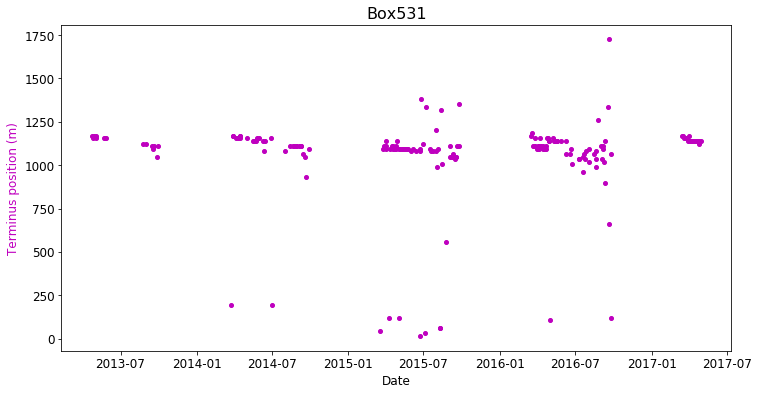

In [1058]:
fig, ax1 = plt.subplots(figsize=(12,6))

#TERMINUS POSITION
ax1.plot(filtered3_df['datetimes'], filtered3_df['term_position'], 'mo', markersize='4')
# ax1 = onepick_df.plot(x='datetimes', y='term_position', color='m', marker='o', linestyle = 'None', figsize=(12,6), legend=None, markersize=4)
ax1.set_ylabel('Terminus position (m)', color='m', fontsize=12)

#TERMINUS CHANGE RATES
# ax2 = ax1.twinx()
# ax2.plot(onepick_df['datetimes'], onepick_df['changerate'], 'bo', markersize='4')
# ax2.set_ylabel('Terminus change rate (m/d)', color = 'b', fontsize=12)

#GENERAL PLOT PARAMETERS
ax1.set_title("Box"+BOI, fontsize=16)
ax1.set_xlabel('Date', fontsize=12)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax2.tick_params(axis='both', which='major', labelsize=12)


#SAVE FIGURE
plt.savefig(csvpaths+"/Figures/Termposition_LS8_m_Box"+BOI+"_"+analysis_date+".png", dpi=200)

plt.show()